# Movie Reviews Classification
NLP | Binary classification | NLTK • spaCy • BERT

***

## Project Description

### The objective

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. For this task will be used a dataset of IMBD movie reviews with polarity labeling to build a model for classifying positive and negative reviews.

*the main goal of this study project is to test different libraries and text encoding techniques.*

### Data description

Here's the description of the fields selected for this task:
- `review`: the review text
- `pos`: the target, `0` for negative and `1` for positive
- `ds_part`: `train`/`test` for the train/test part of dataset, correspondingly  

*The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).*

***

## EDA

### Imports and settings

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.style.use("seaborn-v0_8")
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
sns.set_palette("PRGn")

plt.rcParams["figure.figsize"] = (10, 4)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Read and look at the data

In [3]:
# columns needed for this projeect
cols = ["review","pos","ds_part","start_year","end_year","tconst","rating"]

data = pd.read_csv("datasets/imdb_reviews.tsv", sep="\t", usecols=cols)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tconst      47331 non-null  object
 1   start_year  47331 non-null  int64 
 2   end_year    47331 non-null  object
 3   review      47331 non-null  object
 4   rating      47331 non-null  int64 
 5   pos         47331 non-null  int64 
 6   ds_part     47331 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.5+ MB


In [5]:
data.sample(3)

,tconst,start_year,end_year,review,rating,pos,ds_part
39395,tt0363352,1972,1984,One of the best memories of my childhood. Shou...,10,1,test
2766,tt0112374,1995,\N,Not even worth watching this tacky spoiler rui...,2,0,train
20688,tt0479948,2007,\N,Sometimes a movie is so comprehensively awful ...,1,0,train


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
start_year,47331.0,1989.631235,19.600364,1894.0,1982.0,1998.0,2004.0,2010.0
rating,47331.0,5.484608,3.473109,1.0,2.0,4.0,9.0,10.0
pos,47331.0,0.498954,0.500004,0.0,0.0,0.0,1.0,1.0


In [7]:
data.describe(include="O").T

,count,unique,top,freq
tconst,47331,6648,tt0067445,30
end_year,47331,60,\N,45052
review,47331,47240,Loved today's show!!! It was a variety and not...,5
ds_part,47331,2,train,23796


- The `end_year` column has an object datatype due to having "\N" string in it;
- The are only two rows where values are explicitly missing;
- According to [IMDb site](https://www.imdb.com/interfaces/#:~:text=tconst%20(string)%20%2D-,alphanumeric%20unique%20identifier%20of%20the%20title,-directors%20(array%20of), `tsconst` is the unique identifier of the movie title;
- Several reviews are duplicates;

### Clean the data

Identical review texts won't add new information. Check for any duplicates.

In [8]:
# see how many duplicated reviews there are
data.duplicated(subset=["review"]).sum()

91

In [9]:
# make sure that these duplicates also have the same target value
data.duplicated(subset=["review","pos"]).sum()

91

In [10]:
# drop and reset the index
data.drop_duplicates(subset=["review"], inplace=True)
data.reset_index(drop=True, inplace=True)

# check the number of rows left
data.shape

(47240, 7)

### Movies and reviews over the last 50 years

Calculate the number of movies for each year.

In [11]:
n_movies = (data[["tconst","start_year"]] # select only the title id and the start year
            .drop_duplicates()["start_year"] # drop duplicates and select only the years column
            .value_counts() # count the number of movies realeased each year
            .sort_index())[-50:] # sort and select obly the last 50 years

n_movies.head(3)

1961    8
1962    7
1963    2
Name: start_year, dtype: int64

Calculate the number of reviews made every year

In [12]:
n_reviews = (data.groupby(["start_year","pos"])["pos"]
            .count()
            .unstack())[-50:]

n_reviews.columns = ["neg","pos"]
n_reviews.head(3)

,neg,pos
start_year,,
1961,10.0,33.0
1962,42.0,19.0
1963,1.0,2.0


Calculate the moving average for reviews per movie ratio.

In [13]:
ratio = (
    (data["start_year"].value_counts().sort_index()[-50:] / n_movies)
    .reset_index(drop=True)
    .rolling(5)
    .mean()
)

Make plots.

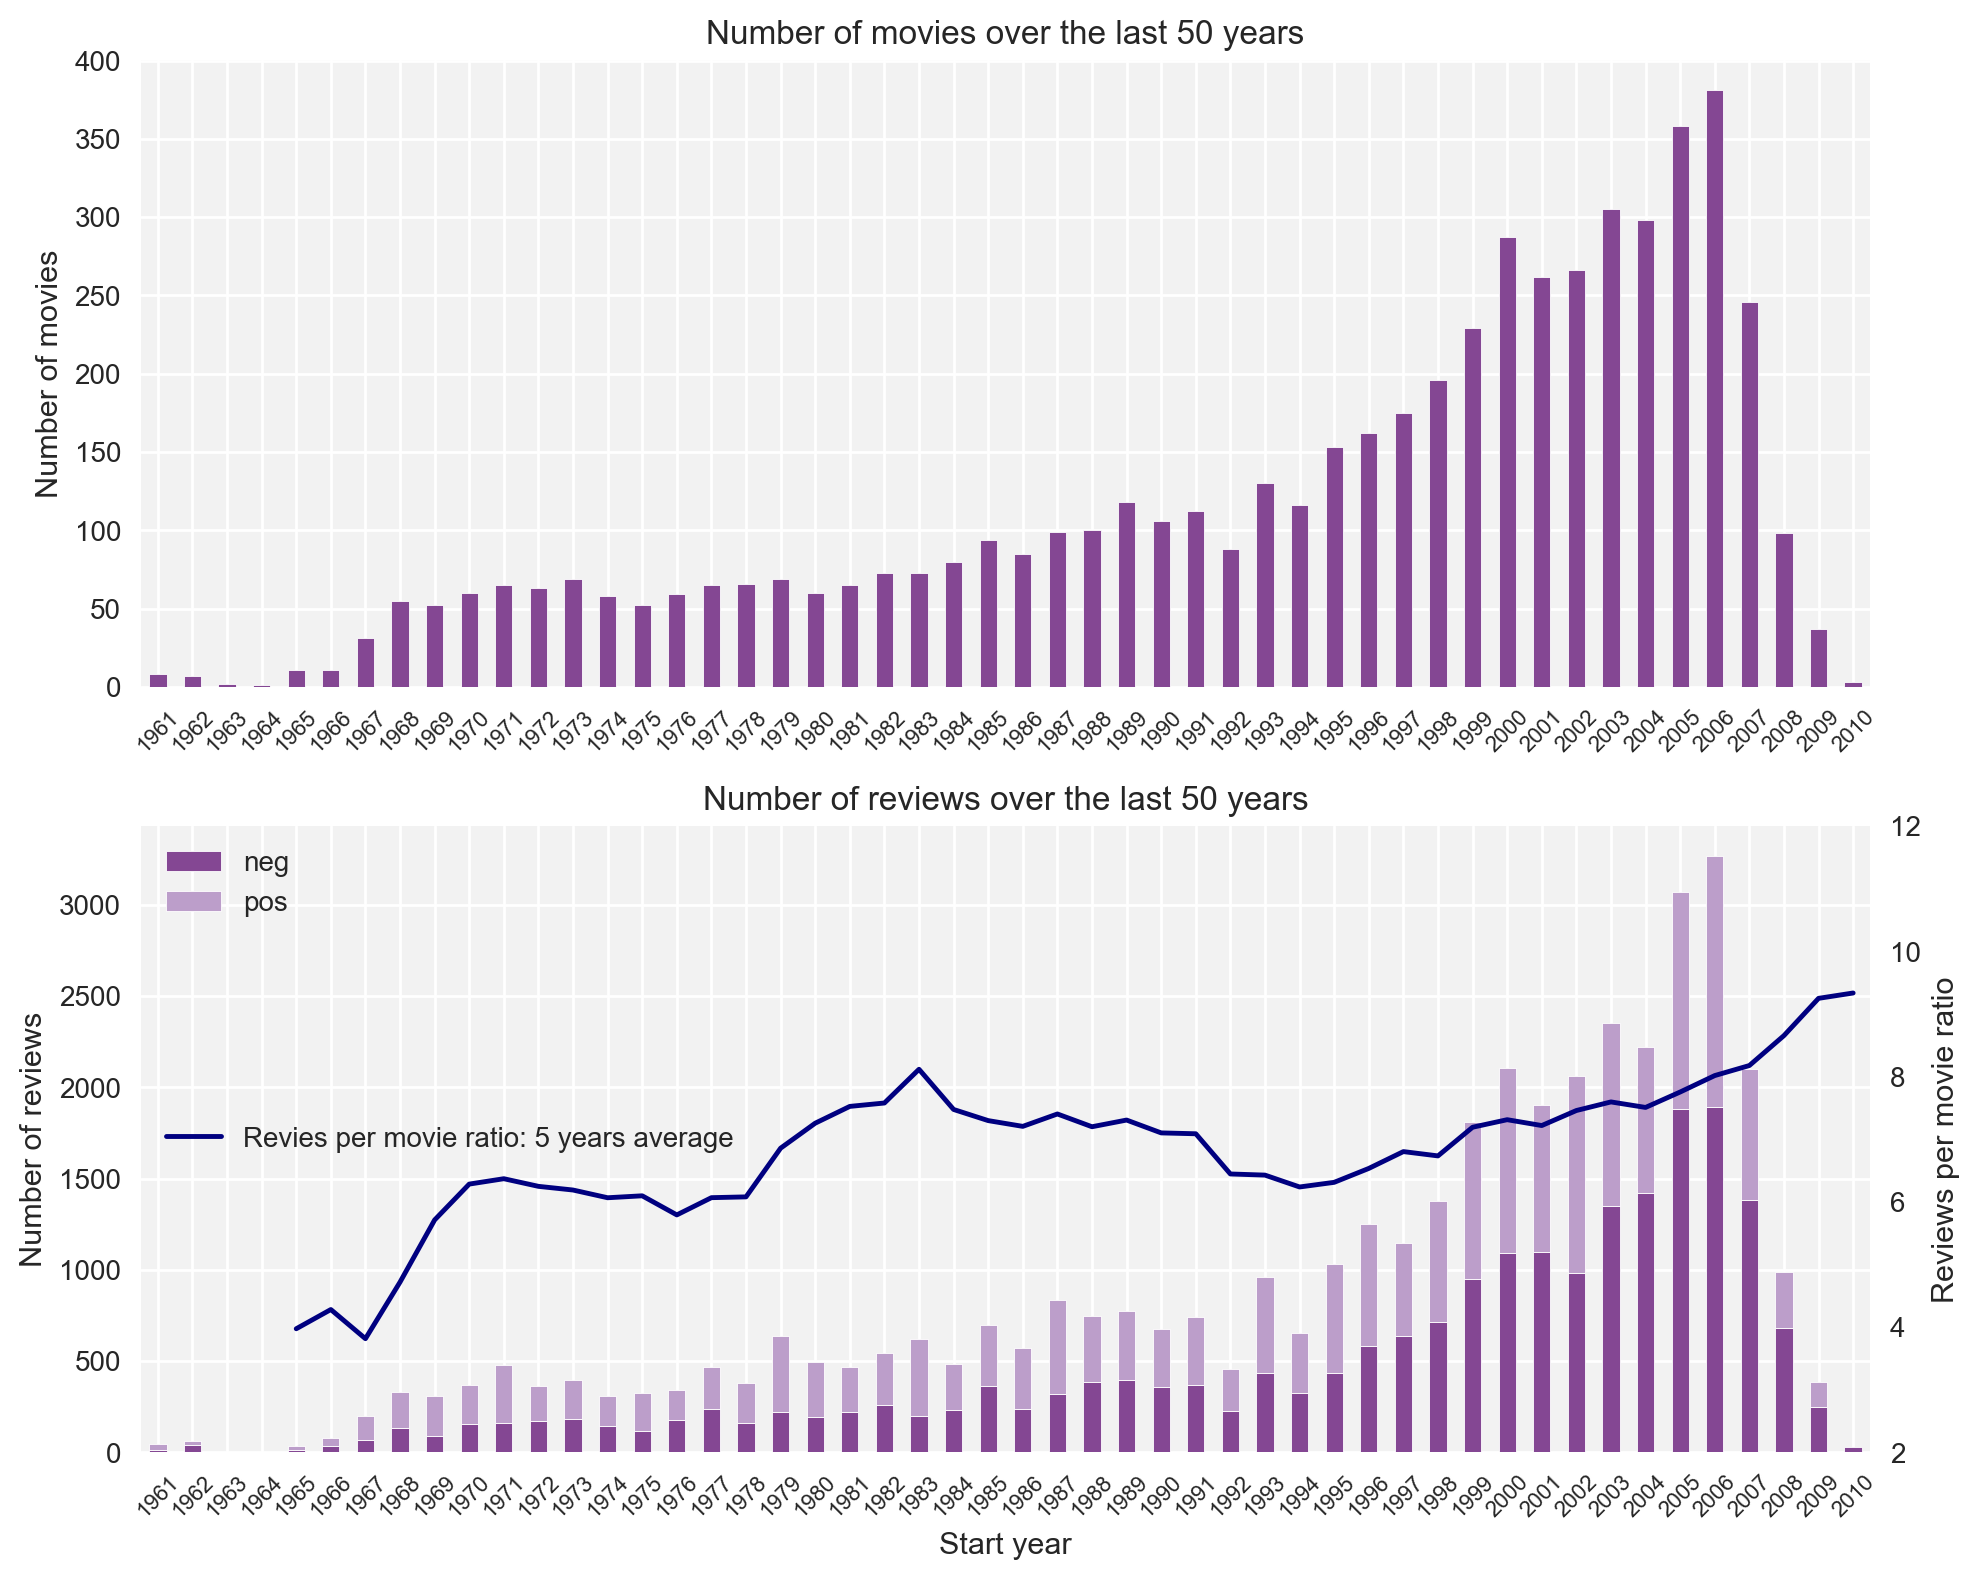

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# plot the number of movies realeased for each year
ax = axs[0] 
n_movies.plot(kind="bar", ax=ax)
ax.set(title="Number of movies over the last 50 years", 
       ylabel="Number of movies")
ax.set_xticklabels(n_movies.index, 
                   fontsize=8, rotation=45)

# plot the number of reviews made
ax = axs[1]
n_reviews.plot(kind="bar", stacked=True, ax=ax)
ax.set(title="Number of reviews over the last 50 years",
       ylabel="Number of reviews", xlabel="Start year")
ax.set_xticklabels(n_reviews.index, 
                   fontsize=8, rotation=45)

# plot the rolling average for reviews per movie ratio
ax_t = ax.twinx()
ratio.plot(label="Revies per movie ratio: 5 years average", 
           grid=False, color="Navy")
ax_t.set_ylabel("Reviews per movie ratio")
ax_t.set_ylim([2, 12])
lines, labels = ax_t.get_legend_handles_labels()
ax_t.legend(lines, labels, loc="center left")

fig.tight_layout();

The average number of reviews per movie increases over the years, although not as drastically as the total number of movies.

### Reviews per movie distribution

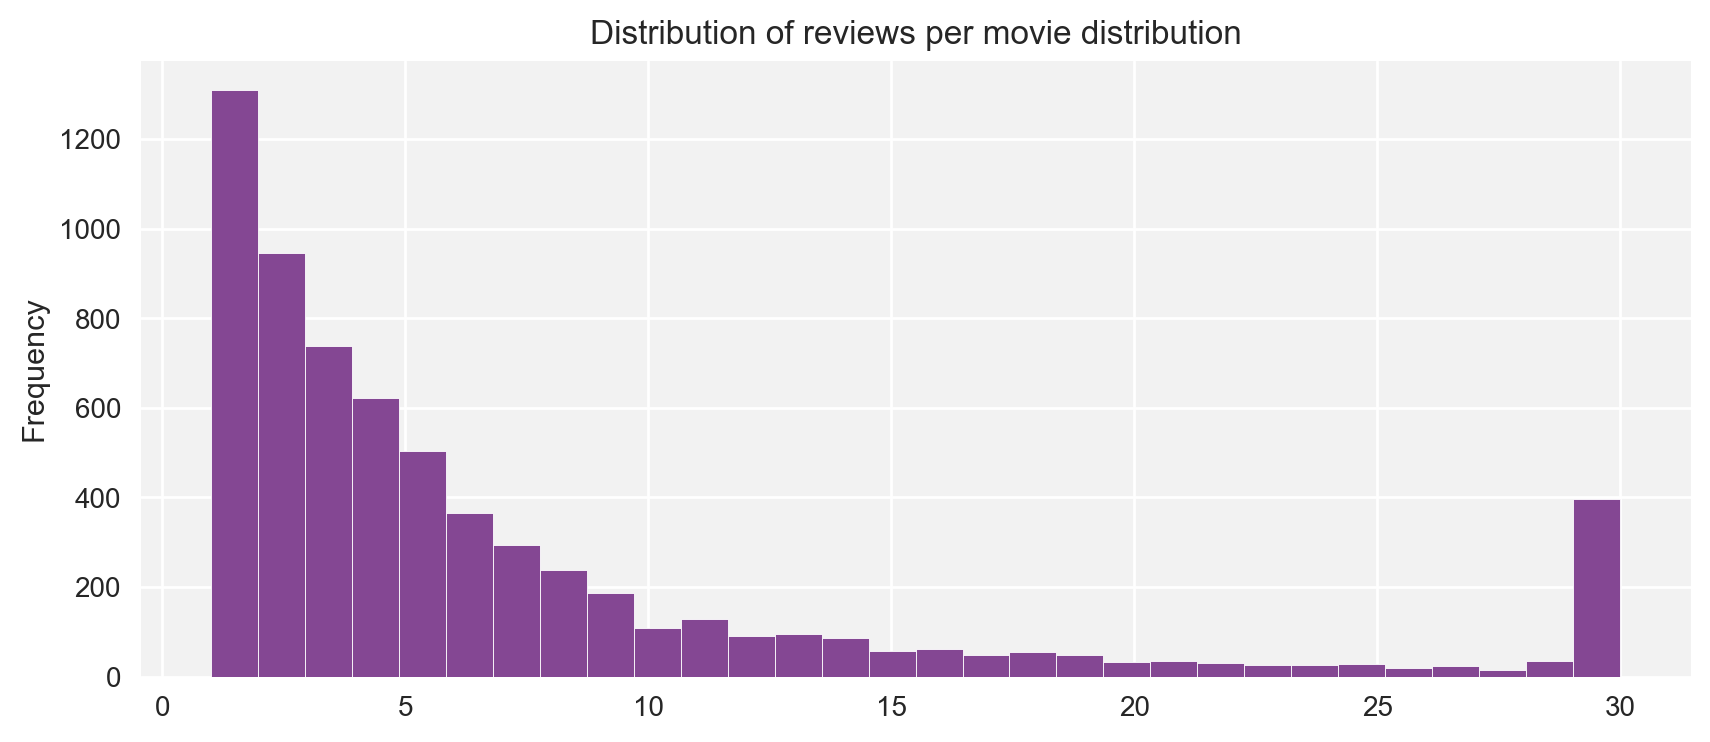

In [15]:
(data
 .groupby("tconst")["review"].count()
 .plot(kind="hist", bins=30, 
       title="Distribution of reviews per movie distribution"));

In most cases movies have few reviews, although there is a spike 30 reviews per movie.

### Target class balance

In [16]:
# check the quantity of each target class in the train data
data[data["ds_part"] == "train"]["pos"].value_counts()

0    11895
1    11862
Name: pos, dtype: int64

In [17]:
data[data["ds_part"] == "test"]["pos"].value_counts()

0    11785
1    11698
Name: pos, dtype: int64

The target class is balanced.

### Ratings distribution

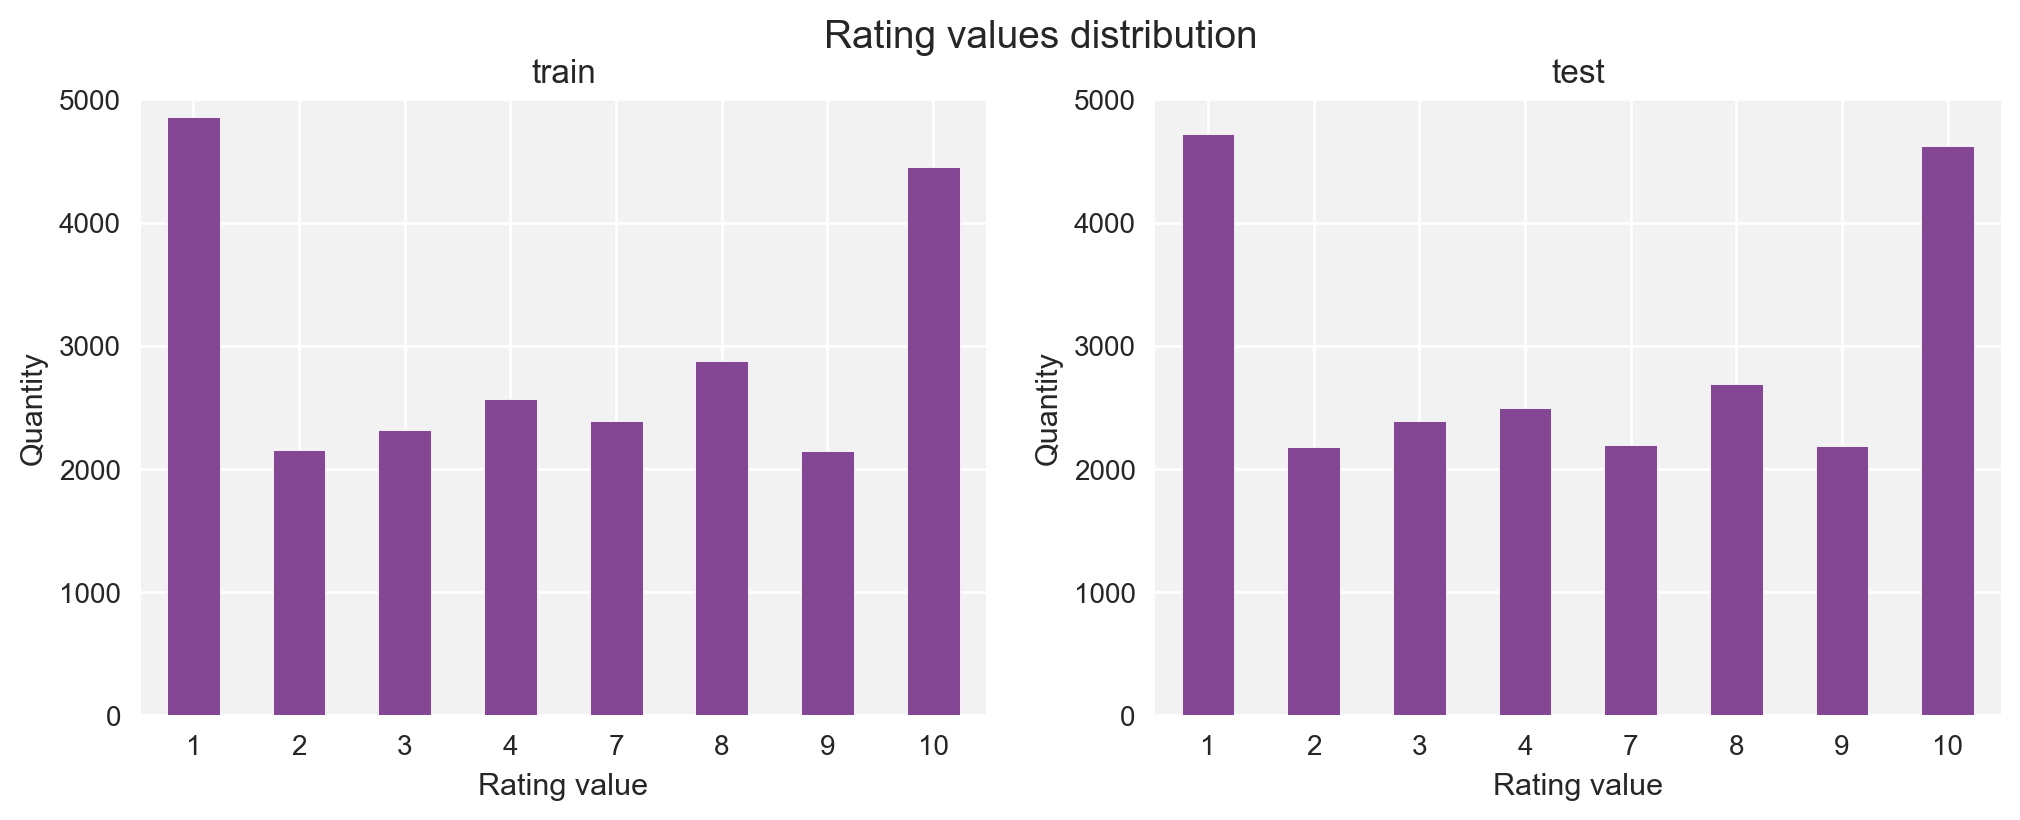

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
plt.suptitle("Rating values distribution", fontsize=14)

for ax_, ds_part in ((0, "train"), (1, "test")):
    
    ax = axs[ax_]
    ratings = (data.query("ds_part == @ds_part")["rating"]
               .value_counts().sort_index()
               .fillna(0))
    
    ratings.plot(kind="bar", ax=ax,rot=0)
    ax.set(title=f"{ds_part}", ylabel="Quantity", xlabel="Rating value")
    ax.set_ylim([0, 5000])

The rating values are present in the train and test parts evenly.

### Neg vs pos reviews distribution

Distribution of negative and positive reviews over the years for two parts of the dataset.

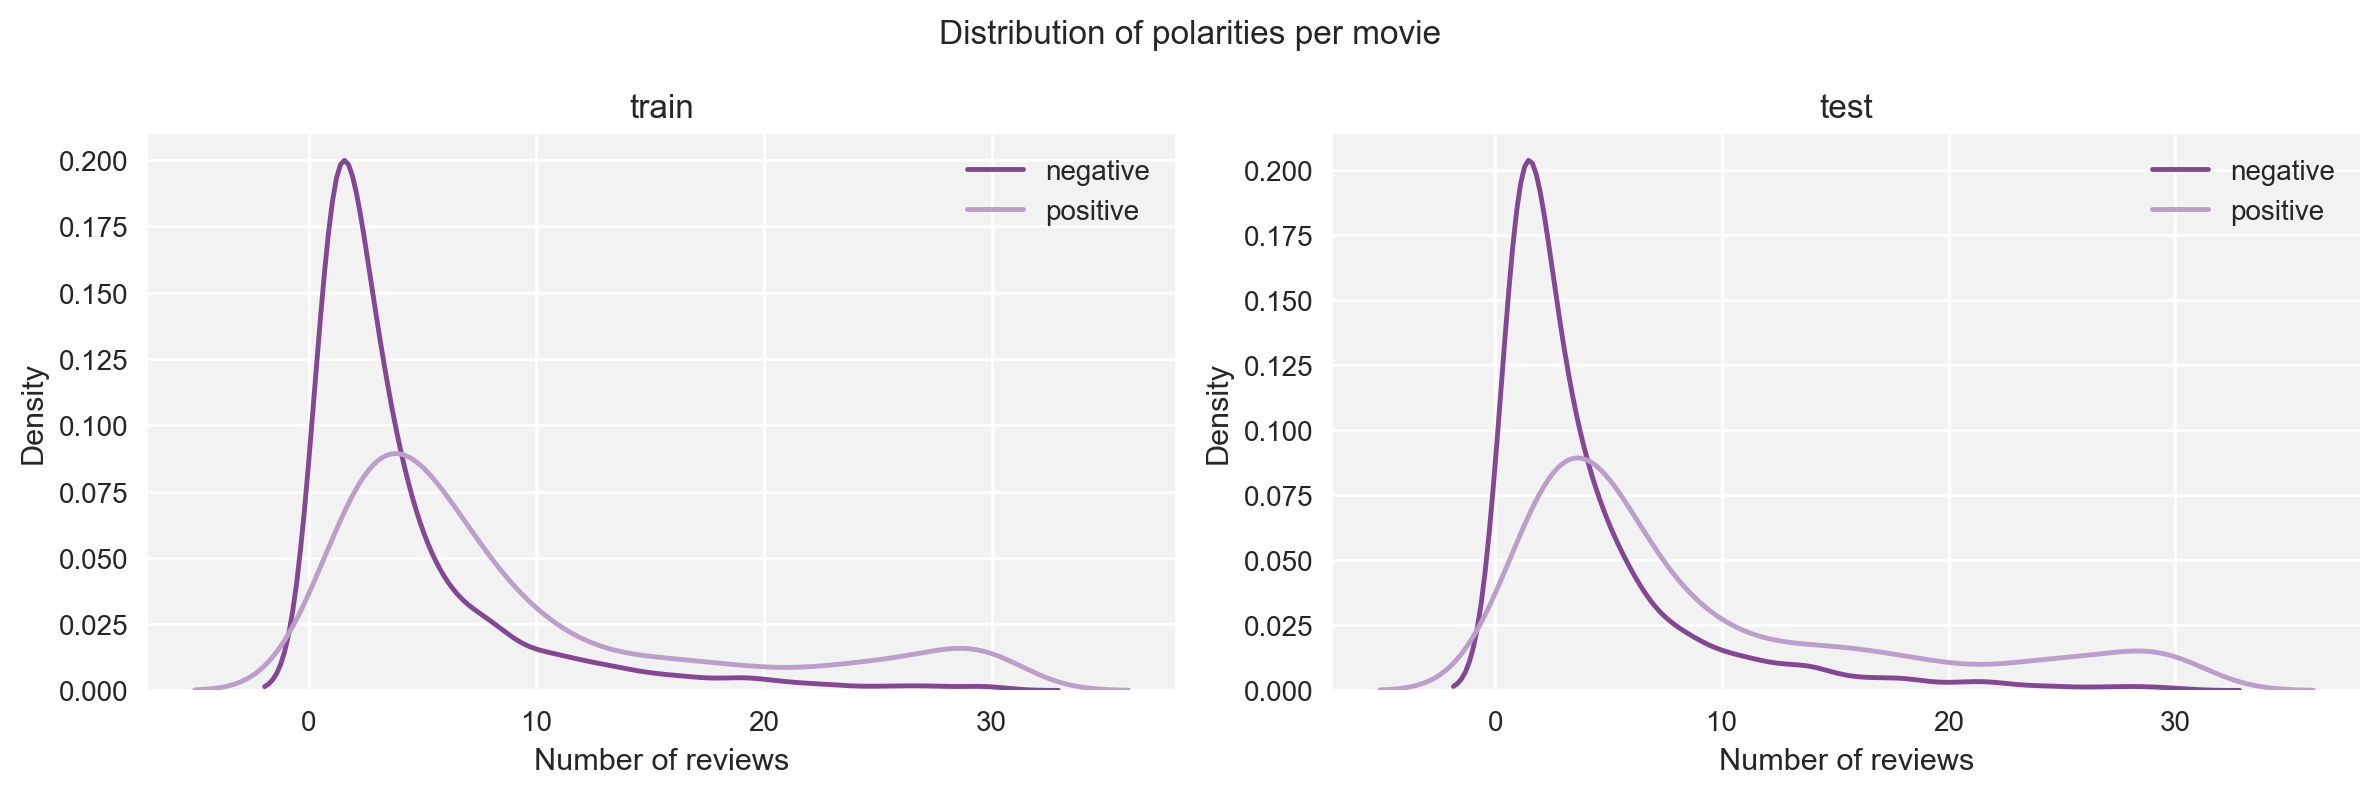

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle("Distribution of polarities per movie")

for ax_, ds_part in ((0, "train"), (1, "test")):
    
    ax = axs[ax_]
    reviews = (data.query("ds_part == @ds_part")
               .groupby(["tconst","pos"])["pos"]
               .count().unstack())
    
    sns.kdeplot(reviews[0], label="negative", ax=ax)
    sns.kdeplot(reviews[1], label="positive", ax=ax)
    ax.set(title=f"{ds_part}", xlabel="Number of reviews")
    ax.legend()
    
fig.tight_layout();


The test and training parts are evenly balanced with fair representation of all features.

***

## Text processing

For this project, several text preprocessing techniques will be used.

### Imports and settings

In [20]:
import math
import re
import time
from tqdm import tqdm

import spacy
import torch
import transformers
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
# this one is to use progress_apply
tqdm.pandas()

### Text normalization

We assume all models in this project accept texts in lowercase and without any digits, punctuation marks, etc.

In [22]:
# create a new colum with a normalized review text
data["review_norm"] = [
    " ".join( # split and join to remove extra spaces made after substitution
        re.sub(r"[^a-z']"," ", text.lower()).split() # substitute all characters 
                                                     # that don't fit the pattern
    ) 
    for text 
    in data["review"]
]

In [23]:
# check how normalization has worked
for index in data.sample(3).index:
    print(" RAW: ", data.loc[index, "review"][:100])
    print("NORM: ", data.loc[index, "review_norm"][:100], "\n")

 RAW:  I am not kidding: there's a scene in this movie where a hobo hits his head on a tunnel keystone and 
NORM:  i am not kidding there's a scene in this movie where a hobo hits his head on a tunnel keystone and e 

 RAW:  I thought the racism and prejudice against Carl Brashear was grossly overdramatized for Hollywood ef
NORM:  i thought the racism and prejudice against carl brashear was grossly overdramatized for hollywood ef 

 RAW:  There's a group of Fox TV executives sitting around a boardroom table wondering what new show to com
NORM:  there's a group of fox tv executives sitting around a boardroom table wondering what new show to com 



### Lemmatize with NLTK

In [24]:
lemmatizer = WordNetLemmatizer()

data["lemmatized_nltk"] = [
    " ".join(# join lemmatized words back into text
         # get lemmas for each word in the text
        [lemmatizer.lemmatize(token) for token in word_tokenize(text)]
    )
    for text
    in data["review_norm"]
]

In [25]:
# check how lemmatization has worked
for index in data.sample(3).index:
    print(" NORM: ", data.loc[index, "review_norm"][:100])
    print("LEMMA: ", data.loc[index, "lemmatized_nltk"][:100], "\n")

 NORM:  i sat with my children as we watched this film we all found it to be a very entertaining movie when 
LEMMA:  i sat with my child a we watched this film we all found it to be a very entertaining movie when bill 

 NORM:  my discovery of the cinema of jan svankmajer opened my eyes to a whole tradition of czech animation 
LEMMA:  my discovery of the cinema of jan svankmajer opened my eye to a whole tradition of czech animation o 

 NORM:  this has to be creepiest most twisted holiday film that i've ever clapped eyes on and that's saying 
LEMMA:  this ha to be creepiest most twisted holiday film that i 've ever clapped eye on and that 's saying  



In [26]:
# create masks for selecting the train and the test set
mask_train = data["ds_part"] == "train"
mask_test = data["ds_part"] == "test"

In [27]:
# vectorize texts
stop_words = set(stopwords.words("english"))

vectorizer_1 = TfidfVectorizer(stop_words=stop_words)

train_features_1 = vectorizer_1.fit_transform(data[mask_train]["lemmatized_nltk"])
test_features_1 = vectorizer_1.transform(data[mask_test]["lemmatized_nltk"])

words_1 = vectorizer_1.get_feature_names_out()

### Lemmatize with spaCy

In [28]:
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

data["lemmatized_spacy"] = [
    " ".join(
        [token.lemma_ for token in nlp(text) if not token.is_stop]
    )
    for text
    in data["review_norm"]
]

In [29]:
# check how lemmatization has worked
for index in data.sample(3).index:
    print(" NORM: ", data.loc[index, "review_norm"][:100])
    print("LEMMA: ", data.loc[index, "lemmatized_spacy"][:100], "\n")

 NORM:  normally when i go on a raid of the local hollywood video i head towards the b horror movies to me t
LEMMA:  normally raid local hollywood video head b horror movie basic principal b horror movie camp value he 

 NORM:  personally while i'm able to appreciate really good movies i also have a strange ability to somewhat
LEMMA:  personally able appreciate good movie strange ability somewhat enjoy crappi crap know time want sit  

 NORM:  sometimes it is difficult to watch films with subtitles in this case danish but the watching is wort
LEMMA:  difficult watch film subtitle case danish watching worth story progress reasoning choice sister care 



In [30]:
# vectorize texts
vectorizer_2 = TfidfVectorizer() # stop words are already excluded

train_features_2 = vectorizer_2.fit_transform(data[mask_train]["lemmatized_spacy"])
test_features_2 = vectorizer_2.transform(data[mask_test]["lemmatized_spacy"])

words_2 = vectorizer_2.get_feature_names_out()

### N-grams vectorizing

Try to train the model with n_grams.

In [31]:
vectorizer_3 = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3))

train_features_3 = vectorizer_3.fit_transform(data[mask_train]["lemmatized_nltk"])
test_features_3 = vectorizer_3.transform(data[mask_test]["lemmatized_nltk"])

words_3 = vectorizer_3.get_feature_names_out()

### Stemming nltk

Preprocess texts using stemming method.

In [32]:
# initialize nltk stamming module 
ps = PorterStemmer()

data["stemmed_nltk"] = [
    " ".join(   # join lemmatized words back into text
        [ps.stem(token) for token in word_tokenize(text)] # get lemmas for each word in the text
    )
    for text
    in data["review_norm"]
]

In [33]:
# check how stemming has worked
for index in data.sample(3).index:
    print("NORM: ", data.loc[index, "review_norm"][:100])
    print("STEM: ", data.loc[index, "stemmed_nltk"][:100], "\n")

NORM:  this movie started out with some semblance of a plot then abandoned it for an endless series of rand
STEM:  thi movi start out with some semblanc of a plot then abandon it for an endless seri of random charac 

NORM:  this movie is one of the worst remakes i have ever seen in my life the acting is laughable and corma
STEM:  thi movi is one of the worst remak i have ever seen in my life the act is laughabl and corman ha not 

NORM:  this complete mess of a movie was directed by bill rebane the man partly responsible for the truly i
STEM:  thi complet mess of a movi wa direct by bill reban the man partli respons for the truli infam anti c 



In [34]:
# vectorize texts
vectorizer_4 = TfidfVectorizer(stop_words=stop_words)

train_features_4 = vectorizer_4.fit_transform(data[mask_train]["stemmed_nltk"])
test_features_4 = vectorizer_4.transform(data[mask_test]["stemmed_nltk"])

words_4 = vectorizer_4.get_feature_names_out()

### BERT embeddings

In [35]:
# initialize Bert modules
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
# compose a script for embeddings creation
def get_bert_embeddings(texts, max_length=512, batch_size=100, 
                        disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    
    for text in tqdm(texts, disable=disable_progress_bar):
        ids = tokenizer.encode(text, add_special_tokens=True,
                               truncation=True, max_length=max_length)
        padded = np.array(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
        

    device = torch.device("mps")    
    model.to(device)
    
    if not disable_progress_bar:
        print("Using the {} device.".format(device))
        
    embeddings = []
    
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [37]:
train_features_5 = get_bert_embeddings(data[mask_train]["review_norm"], batch_size=64)

100%|████████████████████████████████████| 23757/23757 [00:51<00:00, 457.31it/s]


Using the mps device.


100%|█████████████████████████████████████████| 372/372 [19:33<00:00,  3.15s/it]


In [38]:
test_features_5 = get_bert_embeddings(data[mask_test]["review_norm"], batch_size=64)

100%|████████████████████████████████████| 23483/23483 [00:51<00:00, 456.21it/s]


Using the mps device.


100%|█████████████████████████████████████████| 367/367 [19:49<00:00,  3.24s/it]


***

## ML part

### Imports and settings

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

from lightgbm import LGBMClassifier

In [40]:
seed = 12345

### Evaluation Procedure
<a id="evaluation-procedure"></a>

In [41]:
# compose an evaluation routine for all models.
def evaluate_model(model, train_features, 
                   train_target, test_features, test_target):
    """
    Takes in model, train, and valid sets.
    Returns scoring values and plots.
    """
    eval_stats = {}
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    for ds_part, features, target in (("train", train_features, train_target), 
                                      ("test", test_features, test_target)):
        
        eval_stats[ds_part] = {}
        color = "gold" if ds_part == "train" else "steelblue"
        
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:,1]
            
        # F1 Score
        ax = axs[0]
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) 
                    for threshold in f1_thresholds]
        accuracies = [metrics.accuracy_score(target, pred_proba>=threshold) 
                     for threshold in f1_thresholds]
        
        max_f1_score_idx = np.argmax(f1_scores)
        max_accuracy_idx = np.argmax(accuracies)
        
        eval_stats[ds_part]['F1'] = f1_scores[max_f1_score_idx]
        eval_stats[ds_part]['Accuracy'] = accuracies[max_accuracy_idx]
        
        ax.plot(f1_thresholds, f1_scores, color=color, 
                label=f'{ds_part}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        
        # setting the point for the best thershold
        ax.plot(f1_thresholds[max_f1_score_idx], f1_scores[max_f1_score_idx], 
                color="green", marker='o', markersize=7)
        
        # setting crosses for some thresholds
        for threshold in np.arange(0.1, 1.01, 0.1):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], 
                    color=marker_color, marker='X', markersize=5)
            
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score')

        # ROC
        ax = axs[1]    
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[ds_part]["ROC AUC"] = roc_auc
        
        ax.plot(fpr, tpr, color=color, label=f'{ds_part}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in np.arange(0.1, 1.01, 0.1):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], 
                    color=marker_color, marker='X', markersize=5)

        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # Precision Recall Curve
        ax = axs[2]
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        ap_score = metrics.average_precision_score(target, pred_proba) 
        eval_stats[ds_part]["APS"] = ap_score
        
        ax.plot(recall, precision, color=color, label=f'{ds_part}, AP={ap_score:.2f}') 
        # setting crosses for some thresholds
        for threshold in np.arange(0.1, 1.01, 0.1):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], 
                    color=marker_color, marker='X', markersize=5)
            
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([0.48, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title('Precision Recall Curve')        
    
    fig.tight_layout()
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    return df_eval_stats

### Data splitting

Luckily, the whole dataset is already divided into train/test one part (*the corresponding flag is 'ds_part'*).

In [42]:
# store the train and the test parts into 
train_features, train_target = data[mask_train]["review_norm"], data[mask_train]["pos"]
test_features, test_target = data[mask_test]["review_norm"], data[mask_test]["pos"]

print(train_features.shape)
print(test_features.shape)

(23757,)
(23483,)


### Dummy model

In [43]:
# train a dummy model for predicting classes by random
dummy_model = DummyClassifier(strategy="uniform", random_state=555).fit(train_features, train_target)
# check the classes balance of the predicted values
print("Dummy predictions counts:")
pd.Series(dummy_model.predict(test_features)).value_counts()

Dummy predictions counts:


1    11792
0    11691
dtype: int64

,train,test
Accuracy,0.50,0.50
F1,0.67,0.67
APS,0.50,0.50
ROC AUC,0.50,0.50


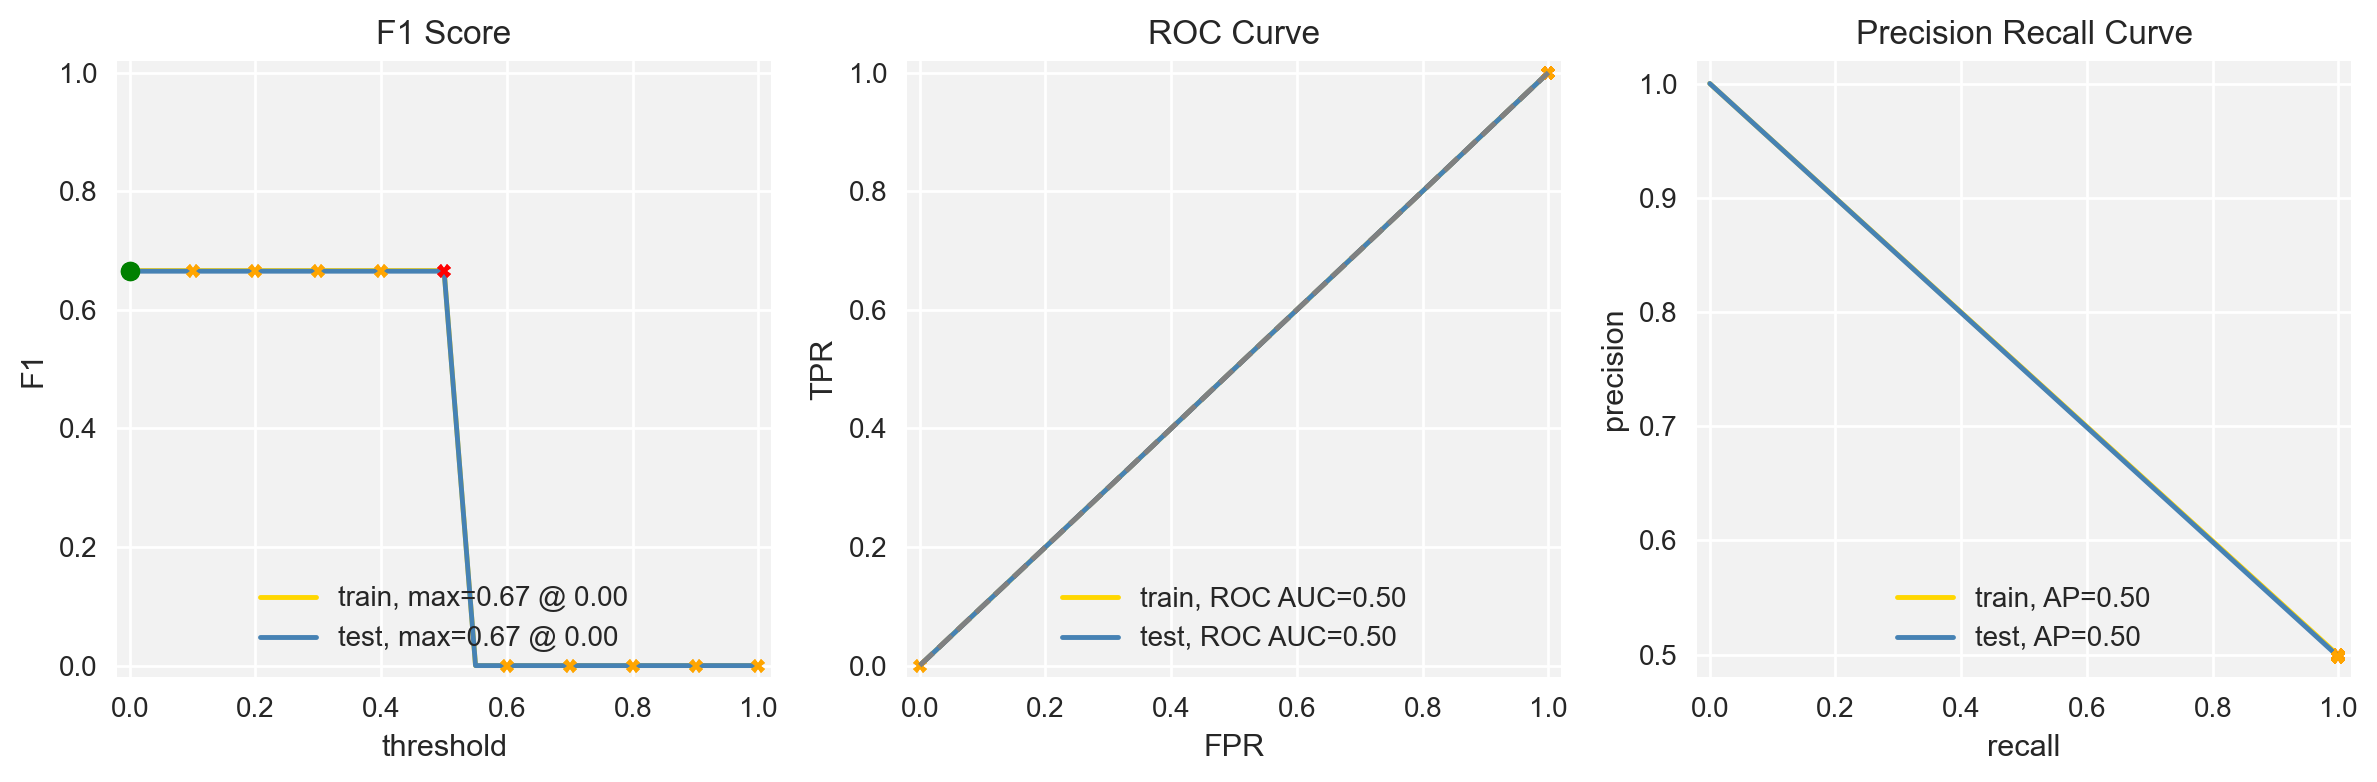

In [44]:
evaluate_model(dummy_model, train_features, train_target, test_features, test_target)

We have a F1 score of 0.67 when using random predictions.

### LogisticRegression

#### LR and NLTK lemmatization

,train,test
Accuracy,0.94,0.88
F1,0.94,0.88
APS,0.98,0.95
ROC AUC,0.98,0.95


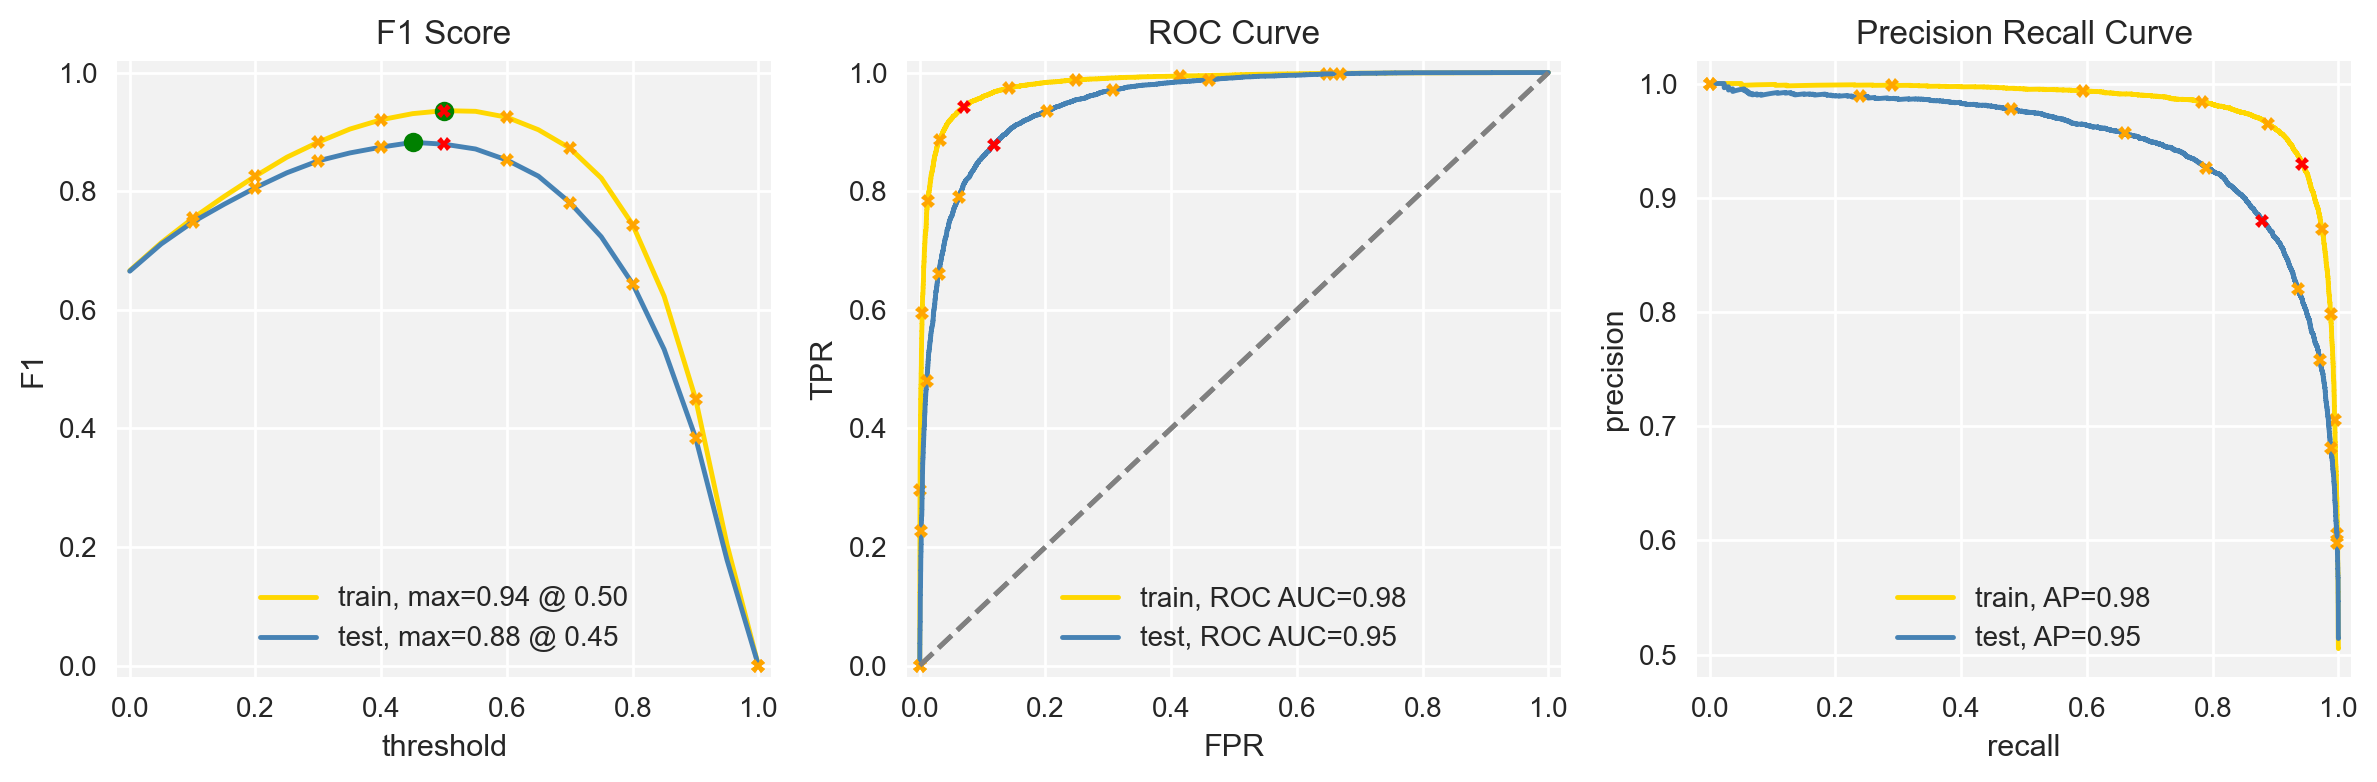

In [45]:
# initialize and fit the model
lr_1 = LogisticRegression().fit(train_features_1, train_target)
# evaluate the model
evaluate_model(lr_1, train_features_1, train_target, test_features_1, test_target)

The LogisticRegression model seem to work quite well. Try to other text processing techniques.

#### LR and spaCy lemmatization

,train,test
Accuracy,0.93,0.87
F1,0.93,0.88
APS,0.98,0.94
ROC AUC,0.98,0.95


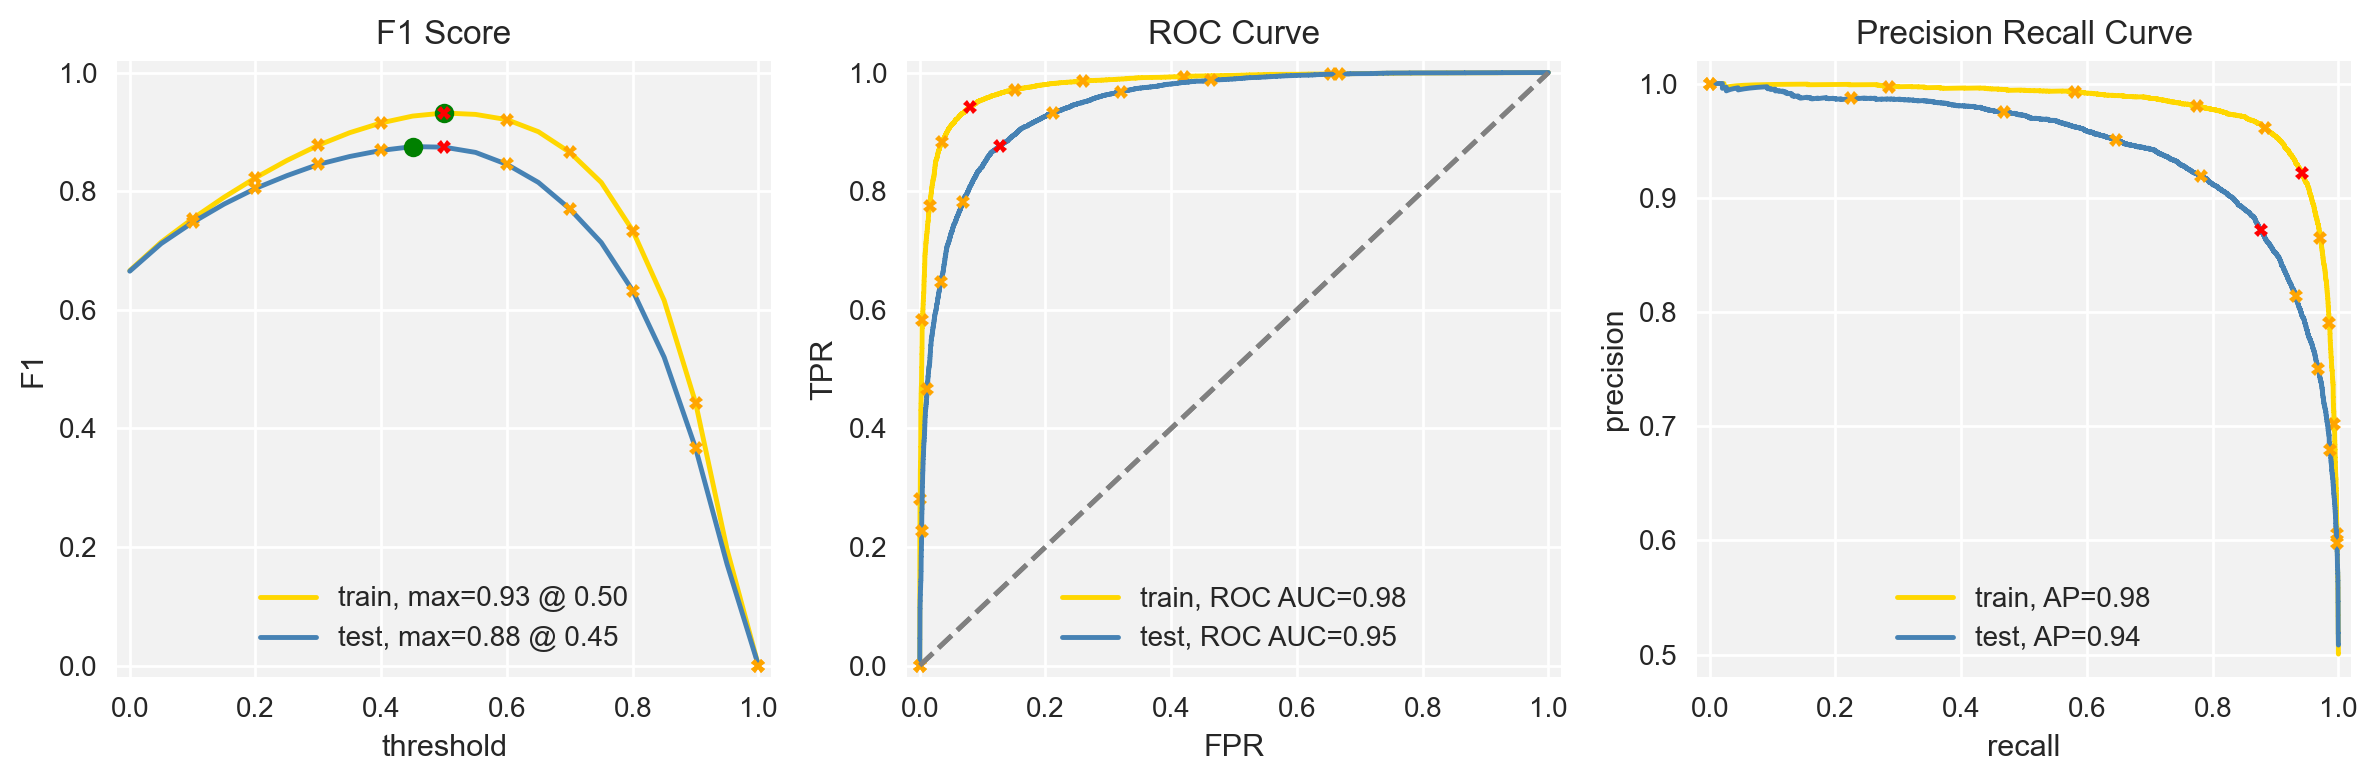

In [46]:
 # initialize and fit the model again
lr_2 = LogisticRegression().fit(train_features_2, train_target)
# evaluate the model
evaluate_model(lr_2, train_features_2, train_target, test_features_2, test_target)

When using spaCy package for lemmatization, the model performs mostly the same, but takes much longer to preprocess texts with spaCy than it is when using nltk.

#### LR and NLTK n_grams

,train,test
Accuracy,0.97,0.87
F1,0.97,0.87
APS,1.00,0.94
ROC AUC,1.00,0.94


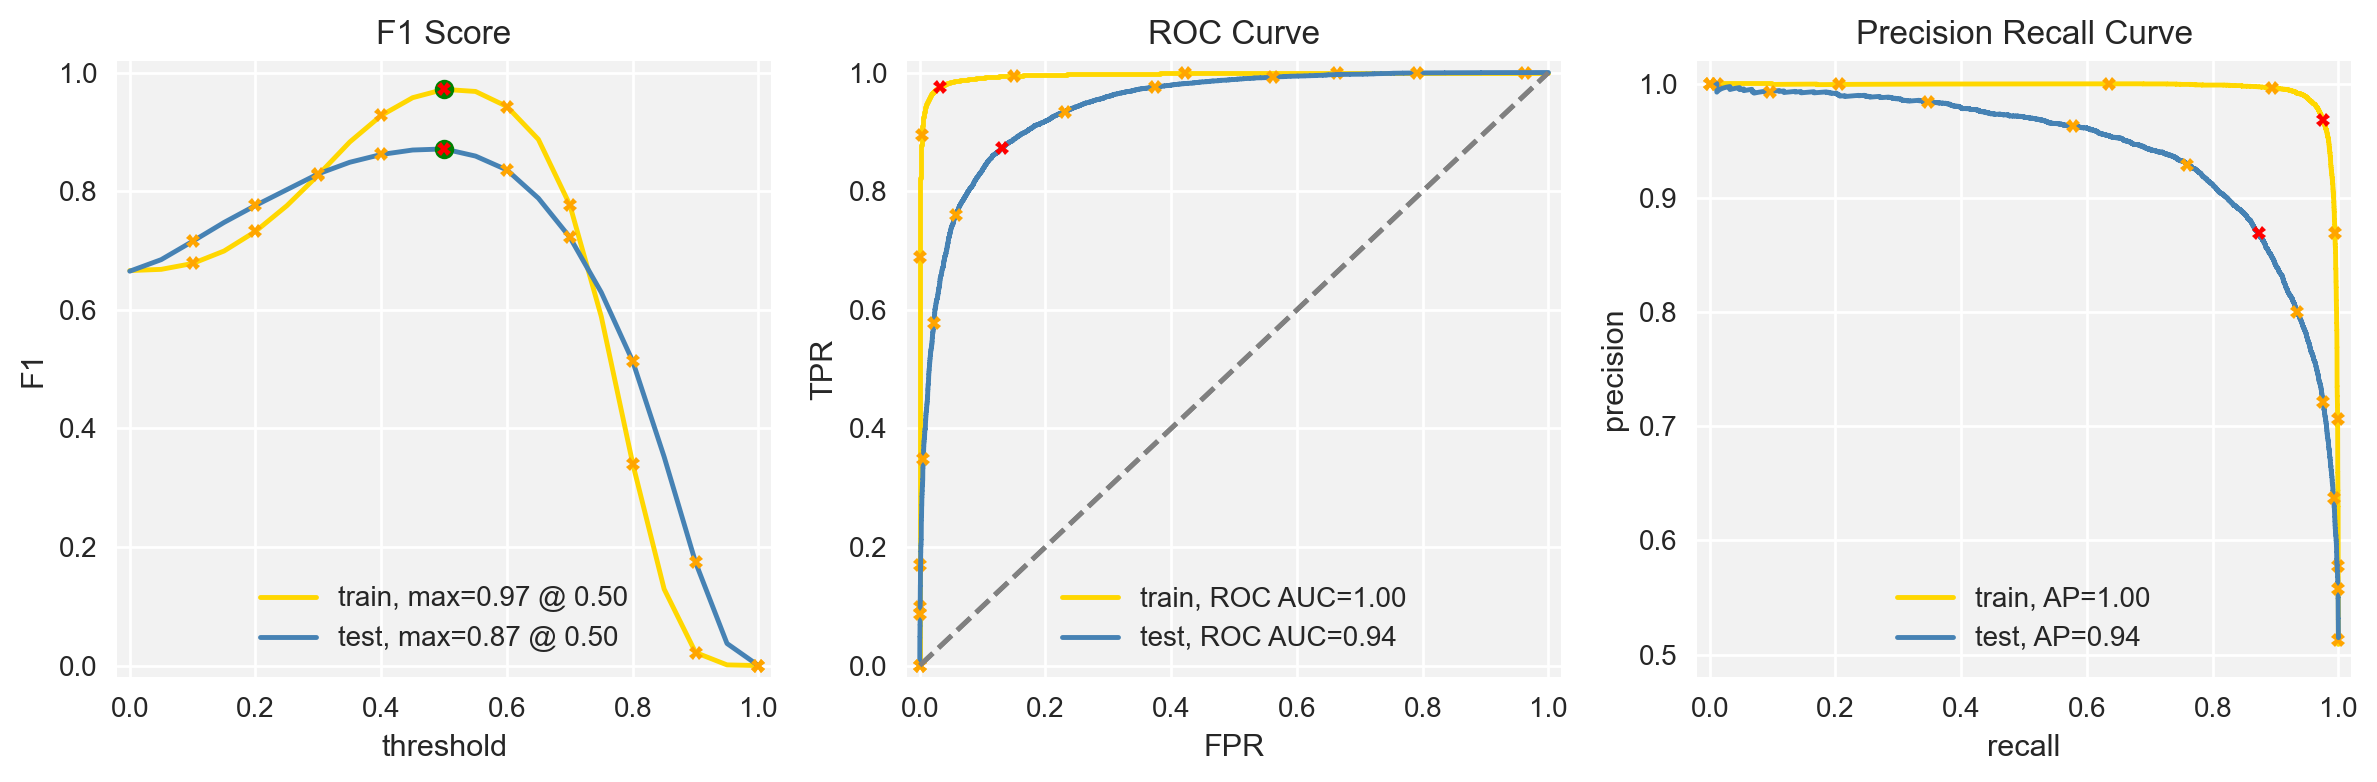

In [47]:
# initialize and fit the model
lr_3 = LogisticRegression().fit(train_features_3, train_target)
# evaluate the model
evaluate_model(lr_3, train_features_3, train_target, test_features_3, test_target)

When using n_grams the model gets overfitted. Try different C to try to improve model's performance.

In [48]:
lr_31 = LogisticRegression()

# parameters grid 
parameters = dict(C=(1,10,100,1000))

# initialize and fit the gridsearch module
lr_31 = GridSearchCV(lr_31, parameters, cv=3, verbose=0, scoring="f1").fit(train_features_3, train_target)

# get the best parameters
lr_31.best_params_

{'C': 1000}

,train,test
Accuracy,1.0,0.89
F1,1.0,0.89
APS,1.0,0.95
ROC AUC,1.0,0.96


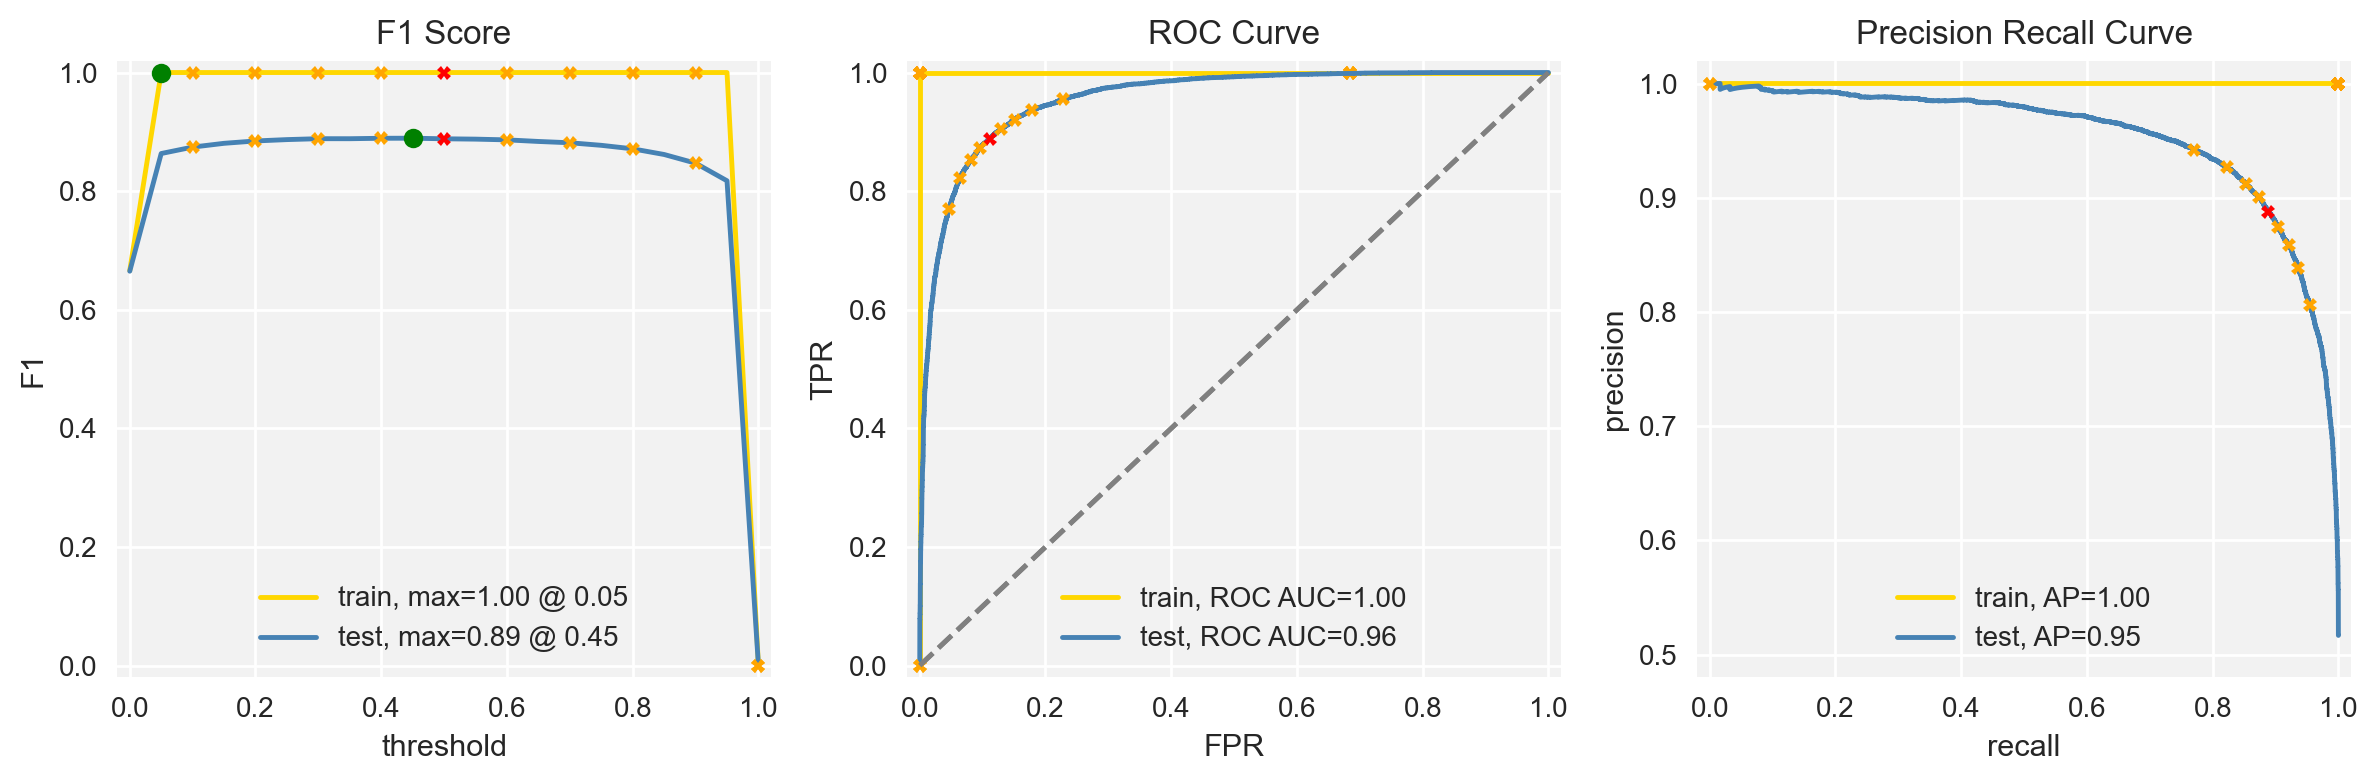

In [49]:
# initialize and fit the model with the regualrization parameter updated
lr_31 = LogisticRegression(C=1000).fit(train_features_3, train_target)
# evaluate the model
evaluate_model(lr_31, train_features_3, train_target, test_features_3, test_target)

Now, the model knows the data perfectly and the key metrics on the validation set are improving.

#### LR and NLTK stemming

,train,test
Accuracy,0.93,0.88
F1,0.93,0.88
APS,0.98,0.95
ROC AUC,0.98,0.95


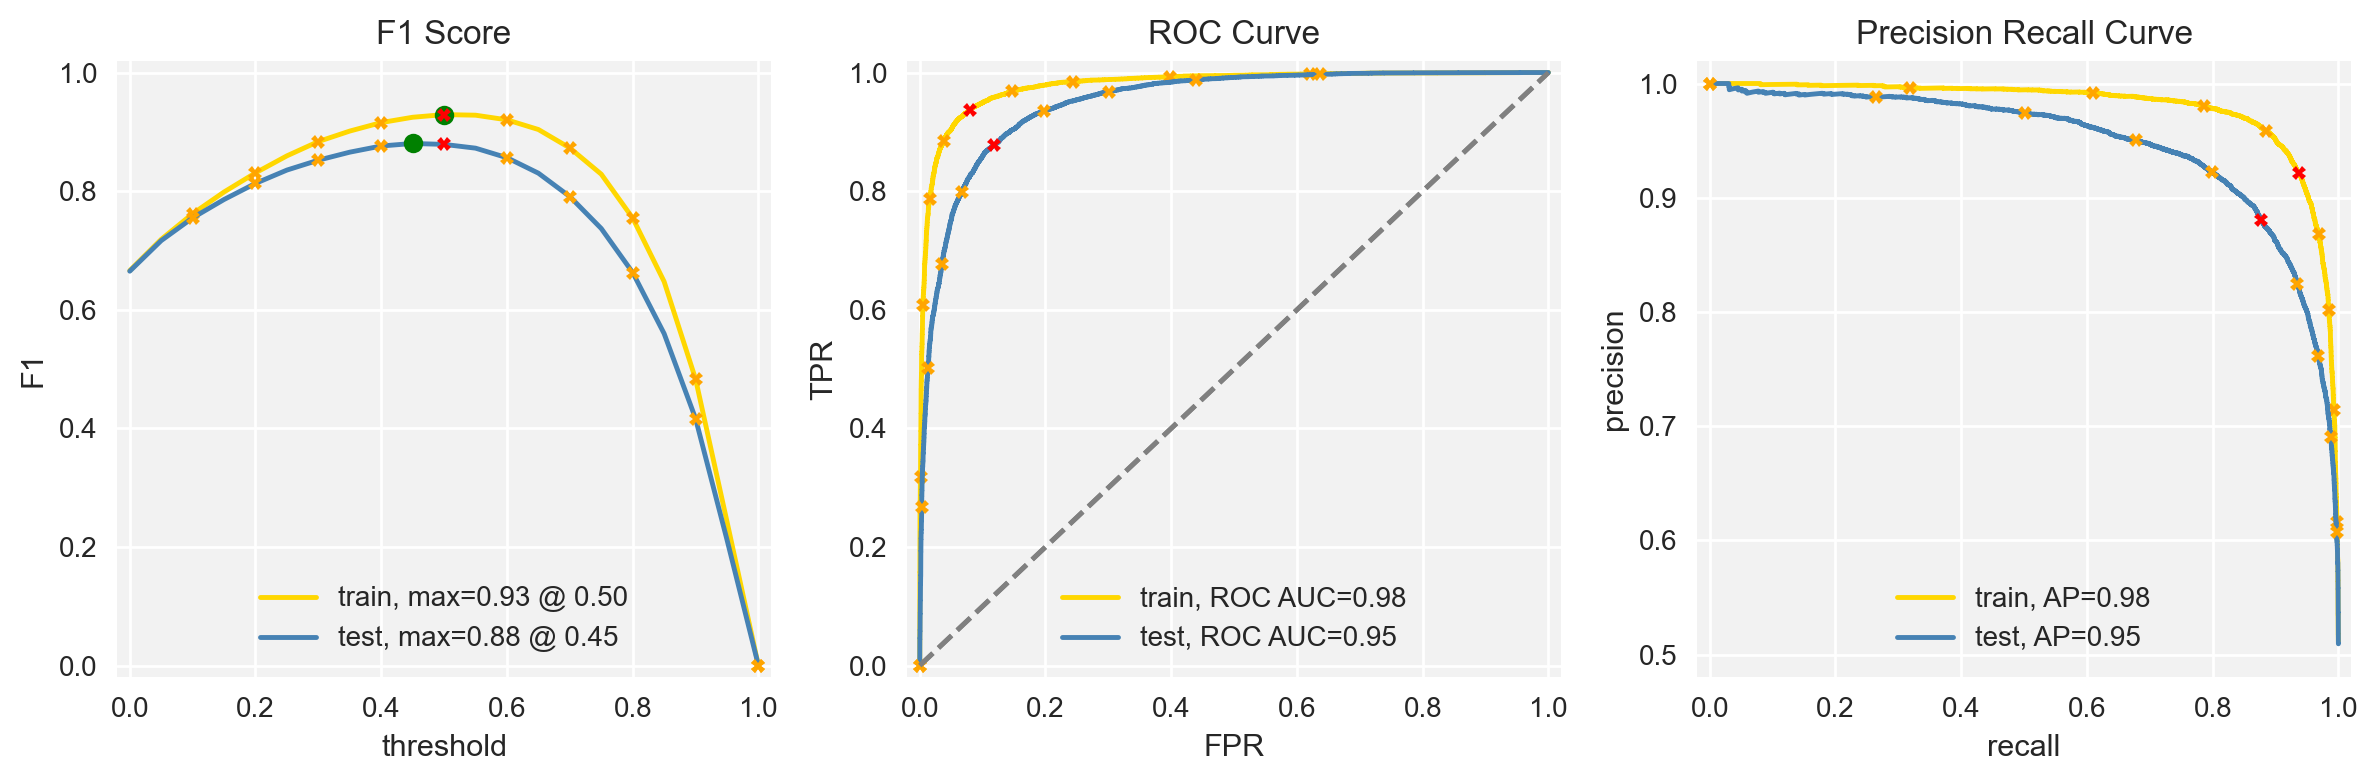

In [50]:
# initialize and fit the model
lr_4 = LogisticRegression().fit(train_features_4, train_target)
# evaluate the model
evaluate_model(lr_4, train_features_4, train_target, test_features_4, test_target)

When texts preprocessed with the stemming method, the LR model yields the same results as it is when using lemmatization.

#### LR and BERT embeddings

,train,test
Accuracy,0.88,0.86
F1,0.88,0.86
APS,0.95,0.94
ROC AUC,0.95,0.94


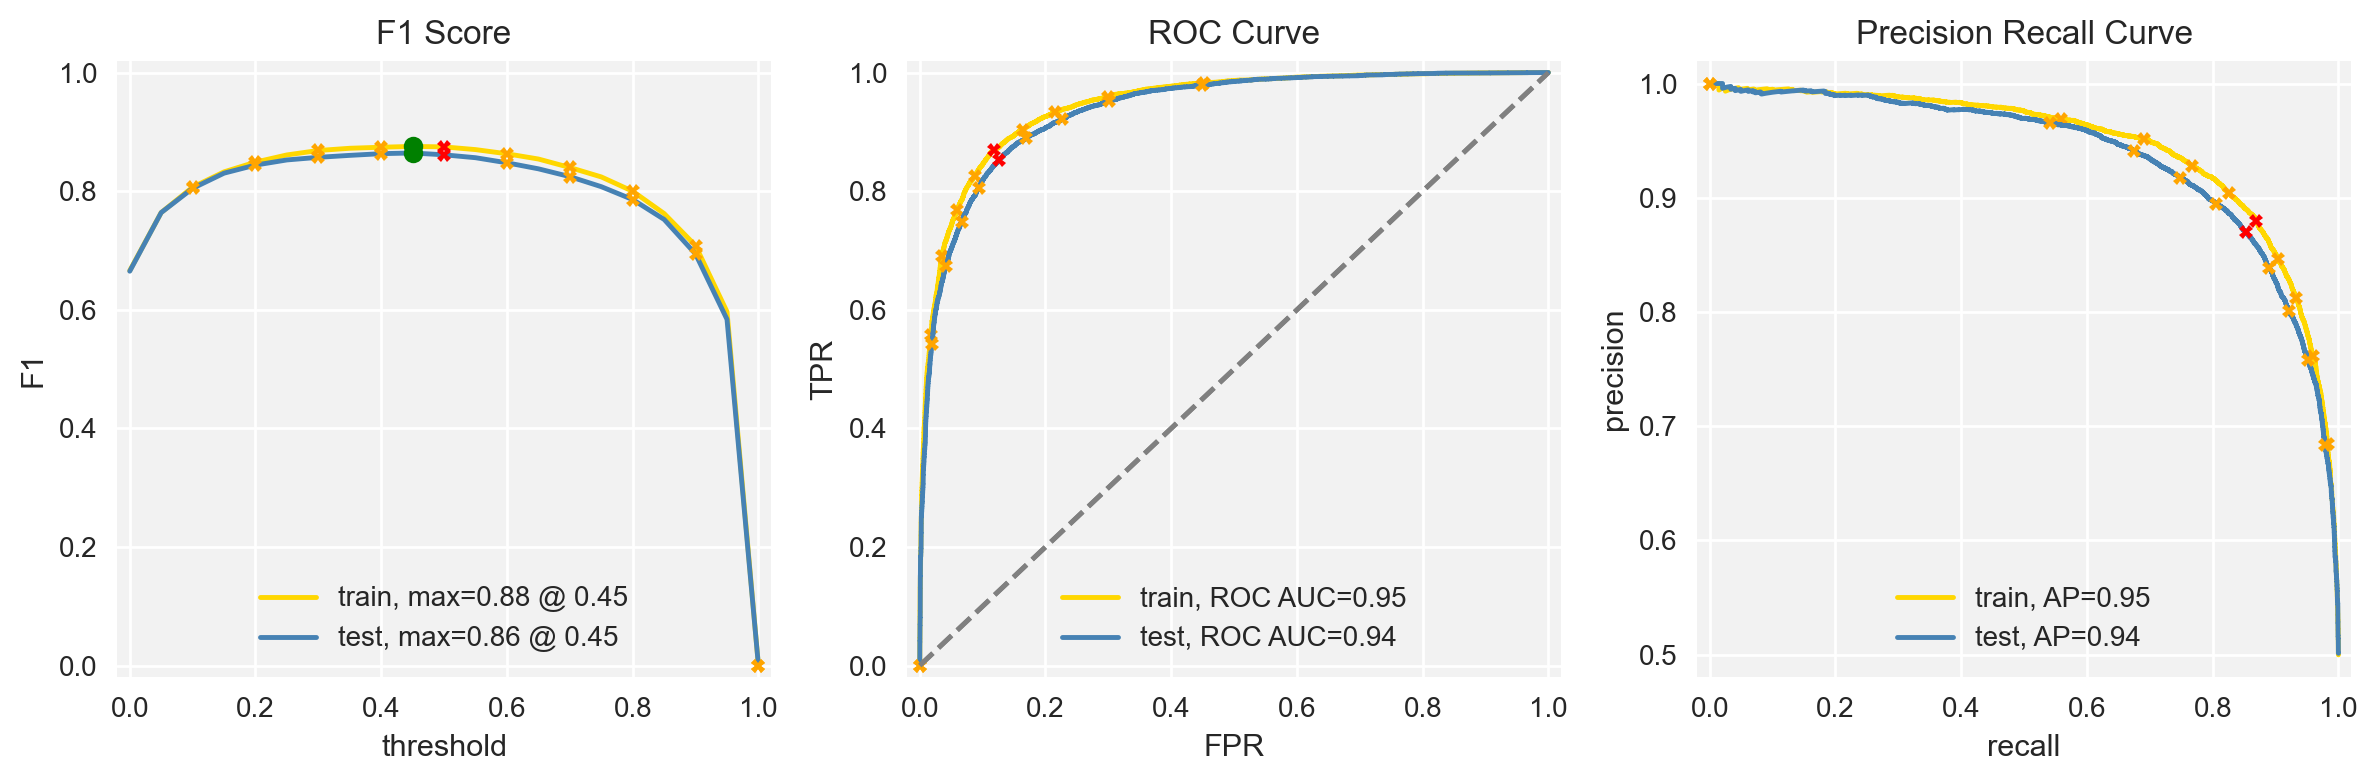

In [51]:
# initialize and fit the model
lr_5 = LogisticRegression().fit(train_features_5, train_target)
# evaluate the model
evaluate_model(lr_5, train_features_5, train_target, test_features_5, test_target)

When using BERT embeddings the model does not overfit. On graphs, the curves for the test data are very close to those for the training set. But the overall performance on the validation set is a bit worse than that with the previous processing methods. 

### RandomForest

#### RF and NLTK lemmatization

,train,test
Accuracy,1.0,0.85
F1,1.0,0.85
APS,1.0,0.91
ROC AUC,1.0,0.92


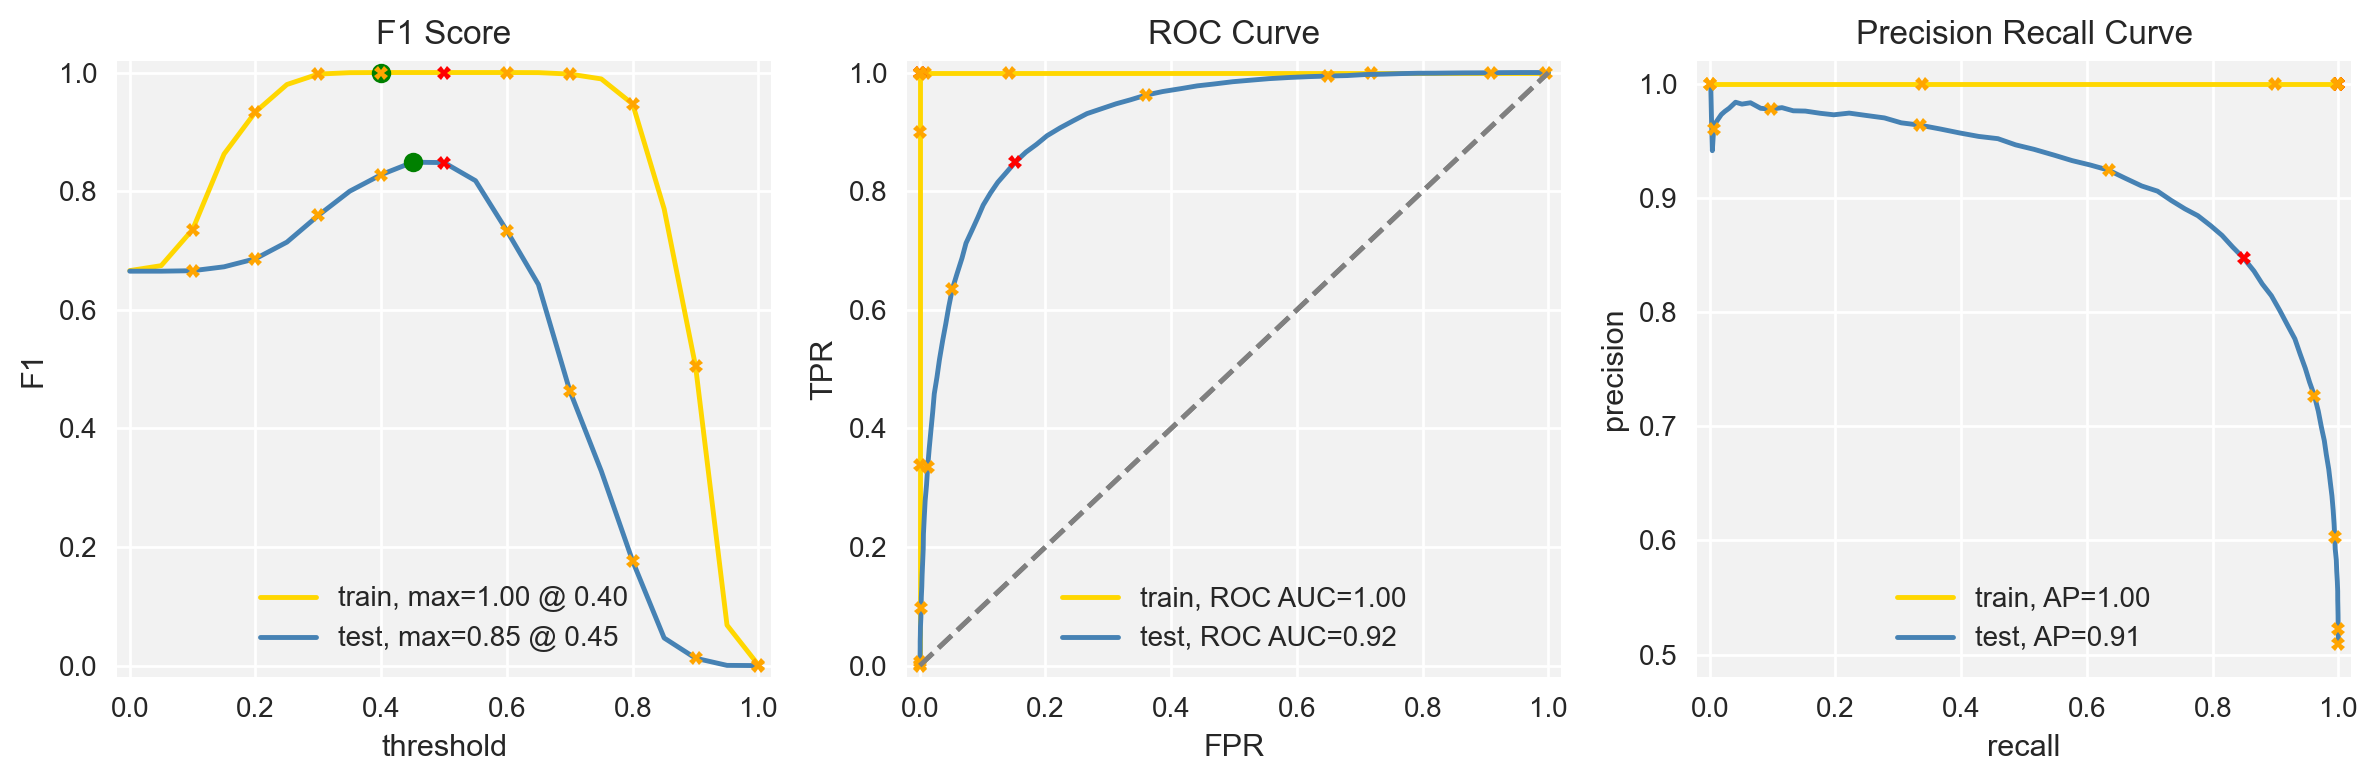

In [52]:
forest_1 = RandomForestClassifier(random_state=12345, n_jobs=-1).fit(train_features_1, train_target)

evaluate_model(forest_1, train_features_1, train_target, test_features_1, test_target)

Try to find better hyperparameters.

In [53]:
f1_best = 0
forest_11 = None

best_depth = 0
best_split = 0
best_leaf = 0
best_n_est = 0

for depth in tqdm(range(30, 101, 10)):
    for split in (2,4,8,16):
        for leaf in (1,2,5):
                
            forest = RandomForestClassifier(
                random_state=12345,
                n_jobs=-1,
                max_depth=depth,
                min_samples_split=split,
                min_samples_leaf=leaf
            )

            f1_scores = cross_val_score(
                forest,
                train_features_1,
                train_target,
                scoring="f1",
                cv=5,
                n_jobs=-1
            )

            f1_average = np.mean(f1_scores)

            if f1_average > f1_best:

                f1_best = f1_average
                forest_11 = forest
                best_depth = depth
                best_split = split
                best_leaf = leaf
                    
print(
    "Best params: ",
    "\nmax depth: ", best_depth,
    "\nmin_samples_split: ", best_split,
    "\nmin_samples_leaf: ", best_leaf,
)

100%|████████████████████████████████████████████| 8/8 [15:24<00:00, 115.61s/it]

Best params:  
max depth:  100 
min_samples_split:  16 
min_samples_leaf:  2


,train,test
Accuracy,0.99,0.85
F1,0.99,0.85
APS,1.00,0.92
ROC AUC,1.00,0.93


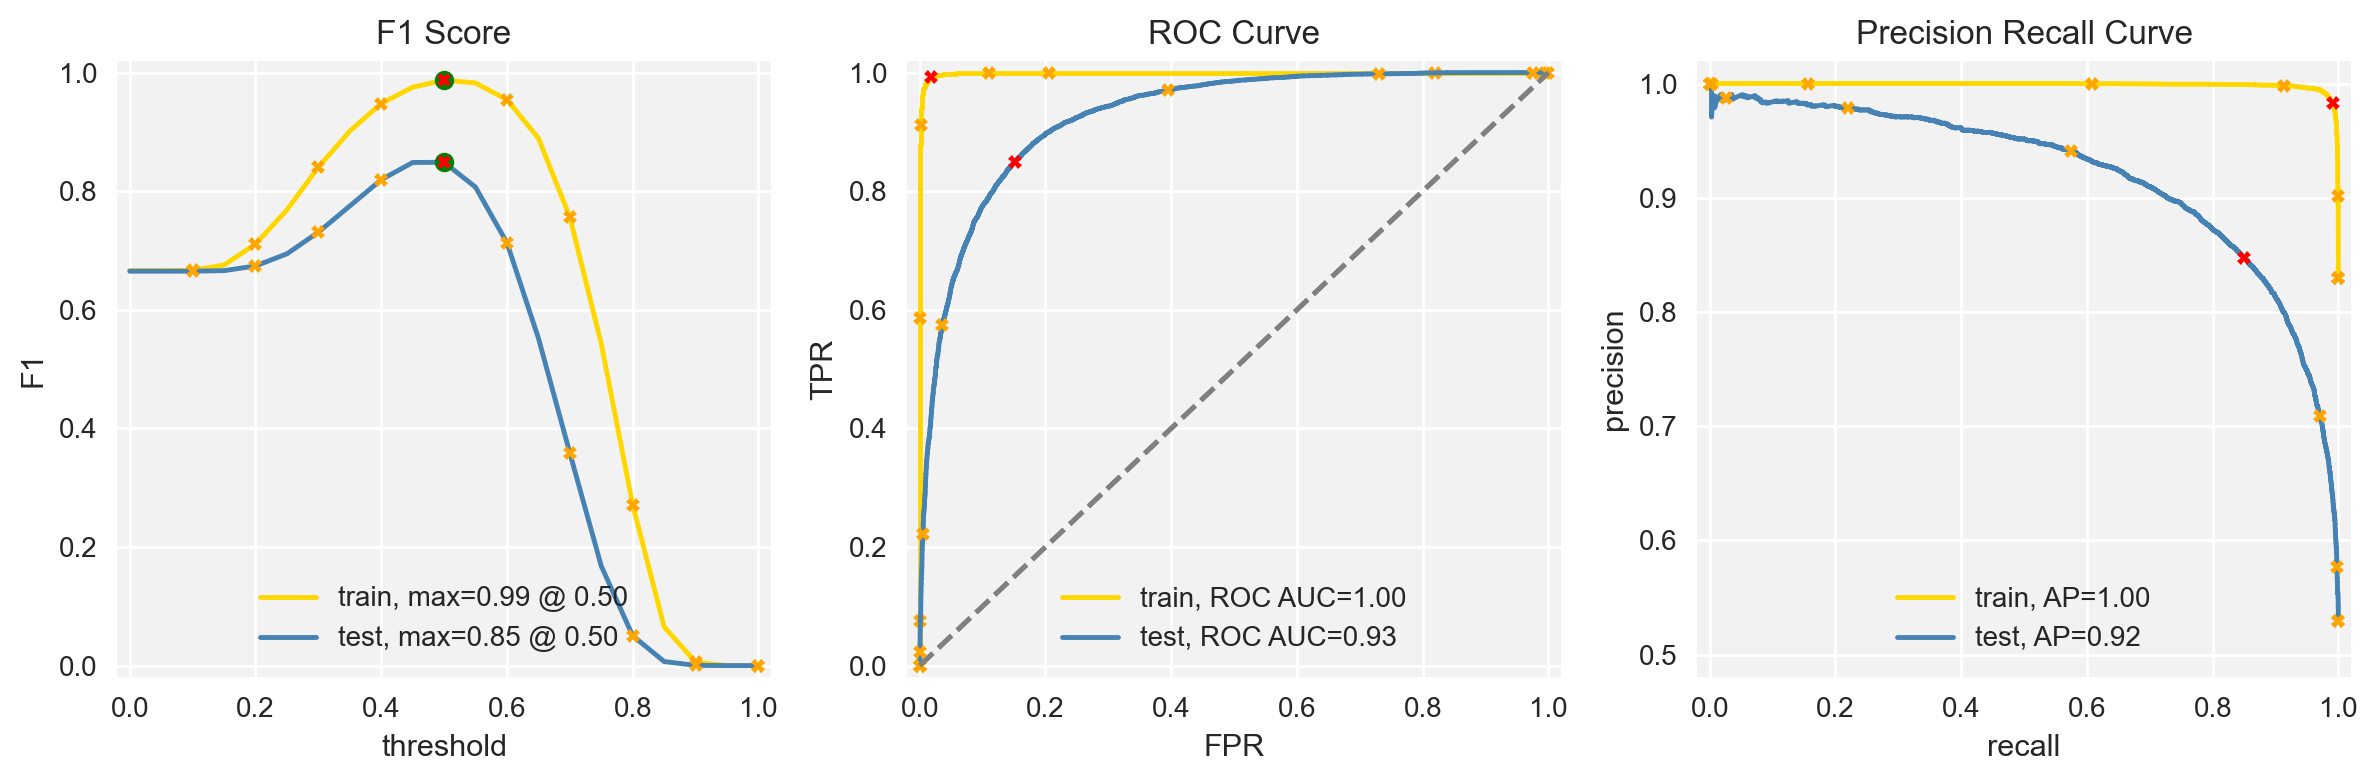

In [54]:
forest_11.fit(train_features_1, train_target)

evaluate_model(forest_11, train_features_1, train_target, test_features_1, test_target)

Not much of improvement.

#### RF and n_grams

,train,test
Accuracy,1.0,0.85
F1,1.0,0.85
APS,1.0,0.91
ROC AUC,1.0,0.92


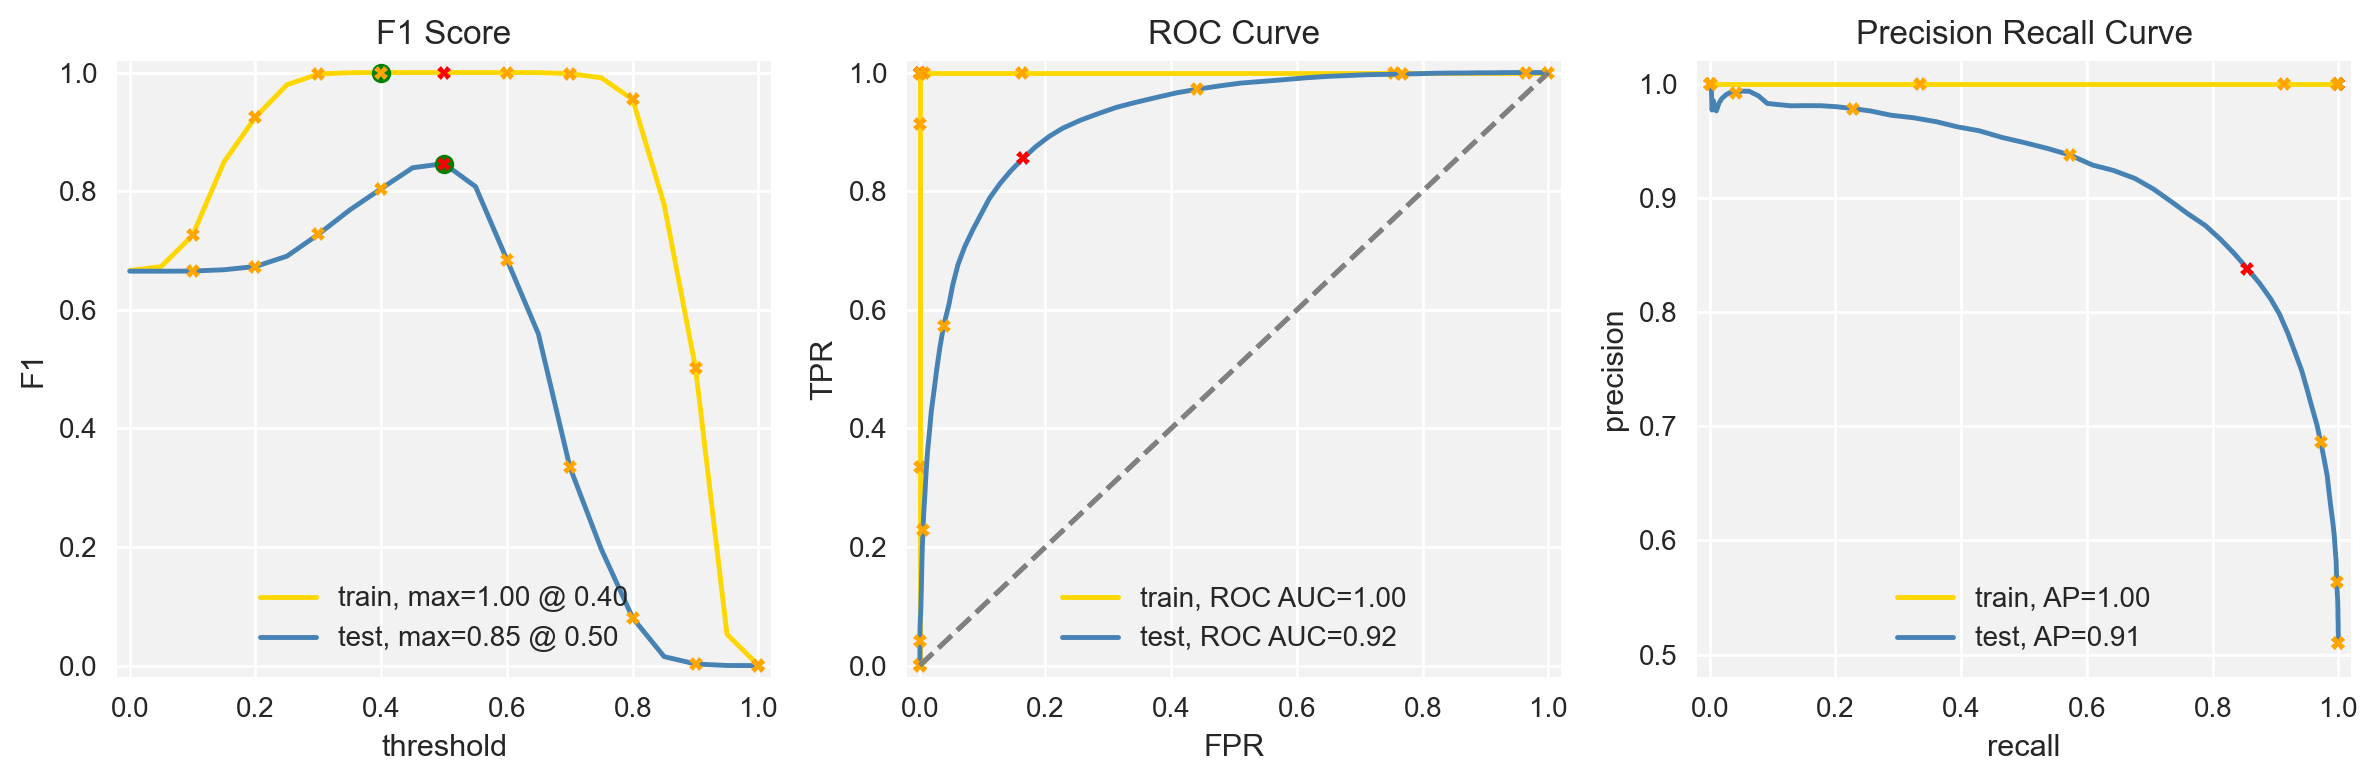

In [55]:
forest_3 = RandomForestClassifier(random_state=12345, n_jobs=-1).fit(train_features_3, train_target)

evaluate_model(forest_3, train_features_3, train_target, test_features_3, test_target)

#### RF and BERT embeddings

,train,test
Accuracy,1.0,0.81
F1,1.0,0.81
APS,1.0,0.89
ROC AUC,1.0,0.89


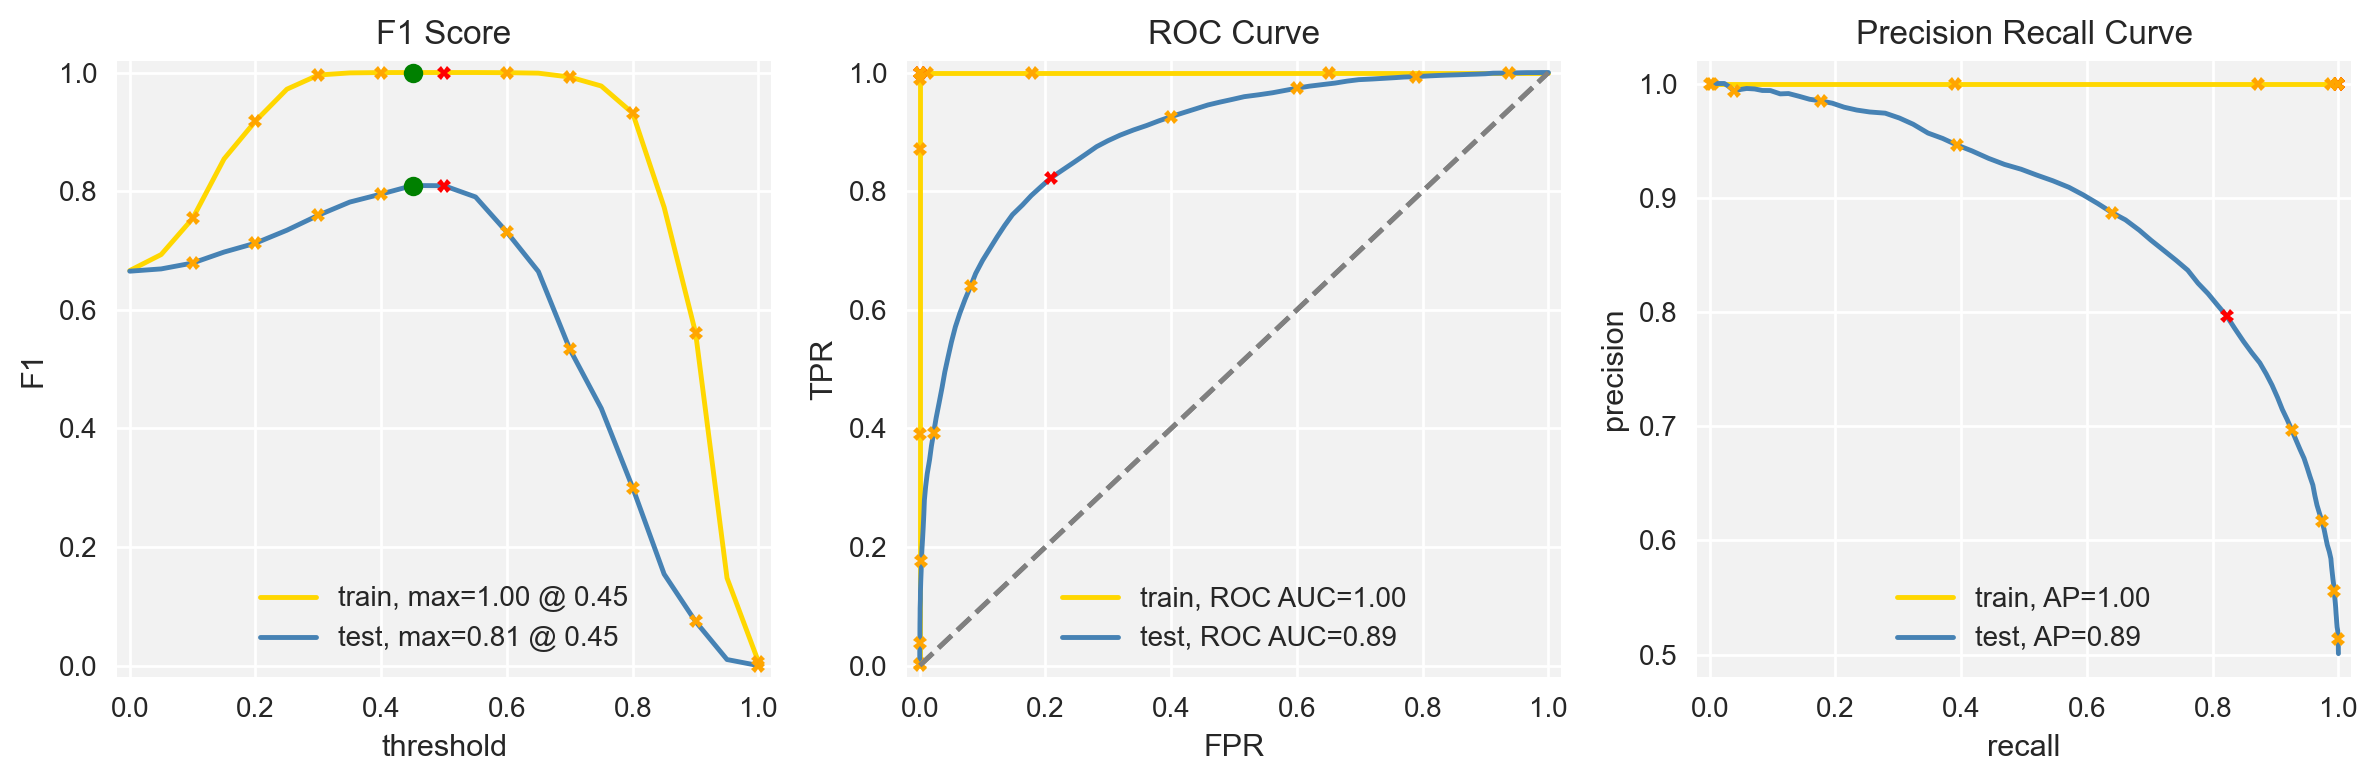

In [56]:
forest_5 = RandomForestClassifier(random_state=12345, n_jobs=-1).fit(train_features_5, train_target)

evaluate_model(forest_5, train_features_5, train_target, test_features_5, test_target)

### LGBMClassifier

#### LGBM and lemmatization

,train,test
Accuracy,0.91,0.86
F1,0.91,0.86
APS,0.97,0.94
ROC AUC,0.97,0.94


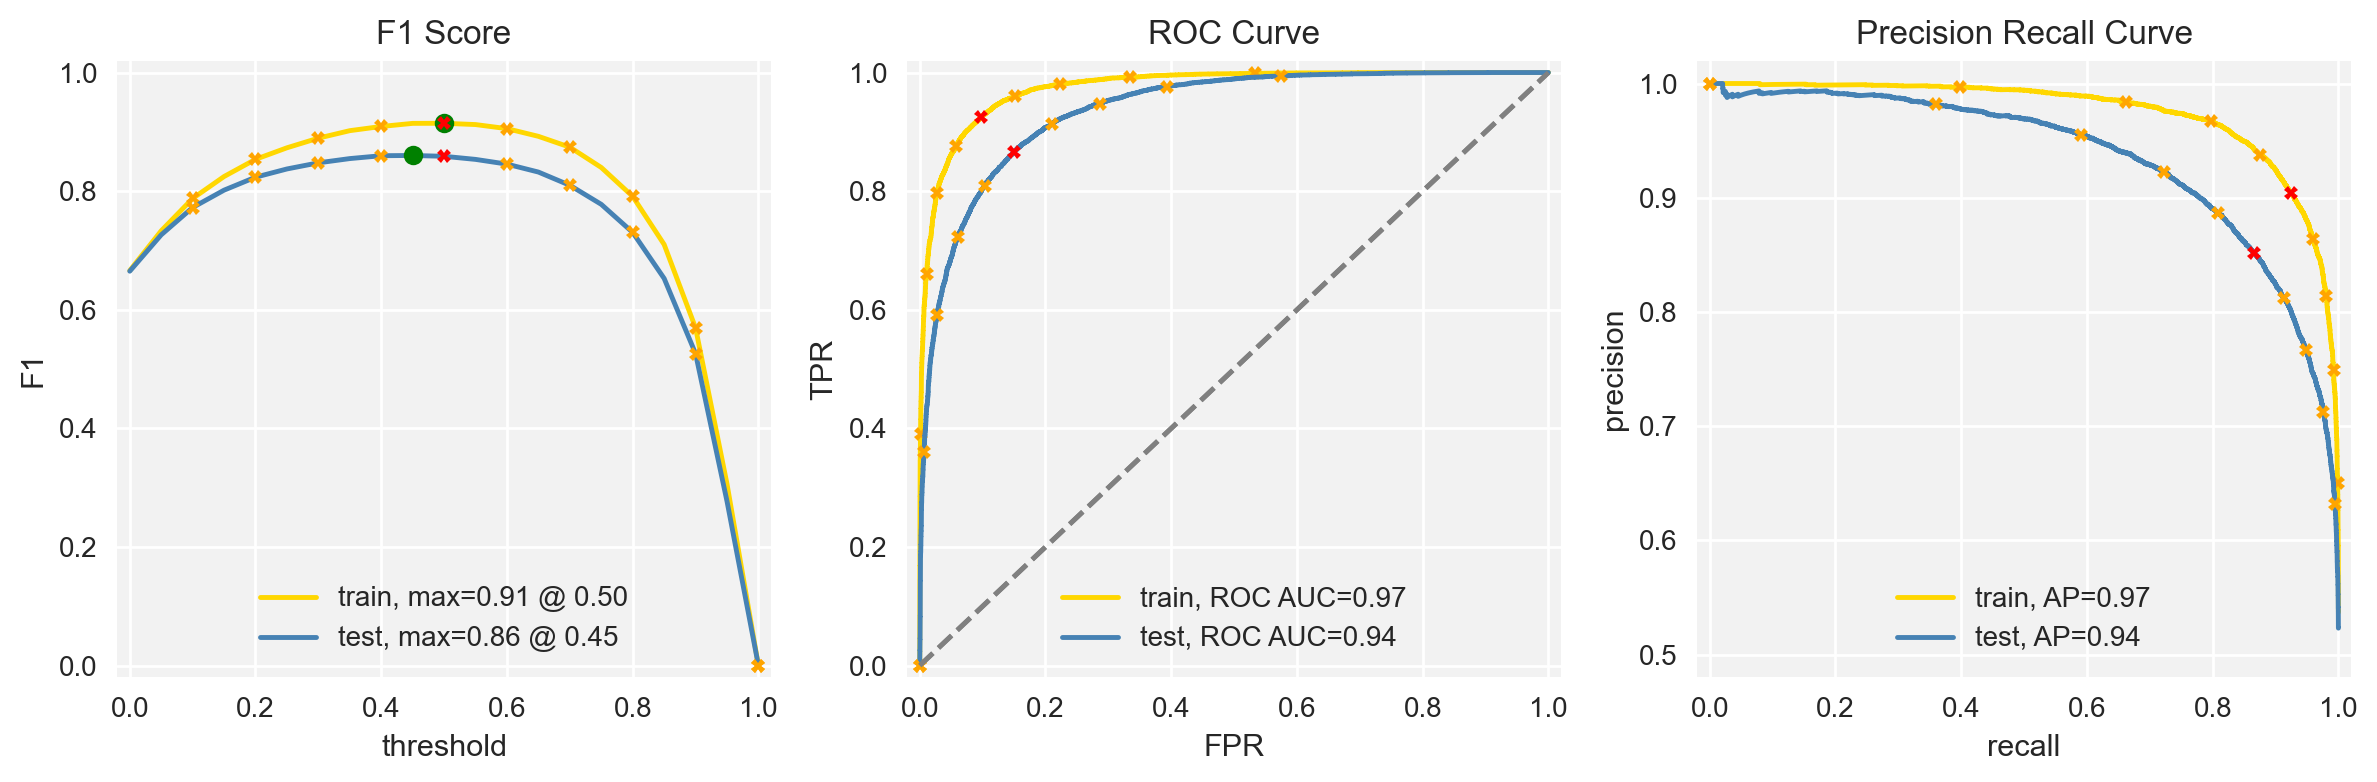

In [57]:
lgbm_1 = LGBMClassifier(random_state=1345, n_jobs=-1).fit(train_features_1, train_target)

evaluate_model(lgbm_1, train_features_1, train_target, test_features_1, test_target)

#### LGBM and n_grams

,train,test
Accuracy,0.92,0.86
F1,0.92,0.86
APS,0.97,0.94
ROC AUC,0.98,0.94


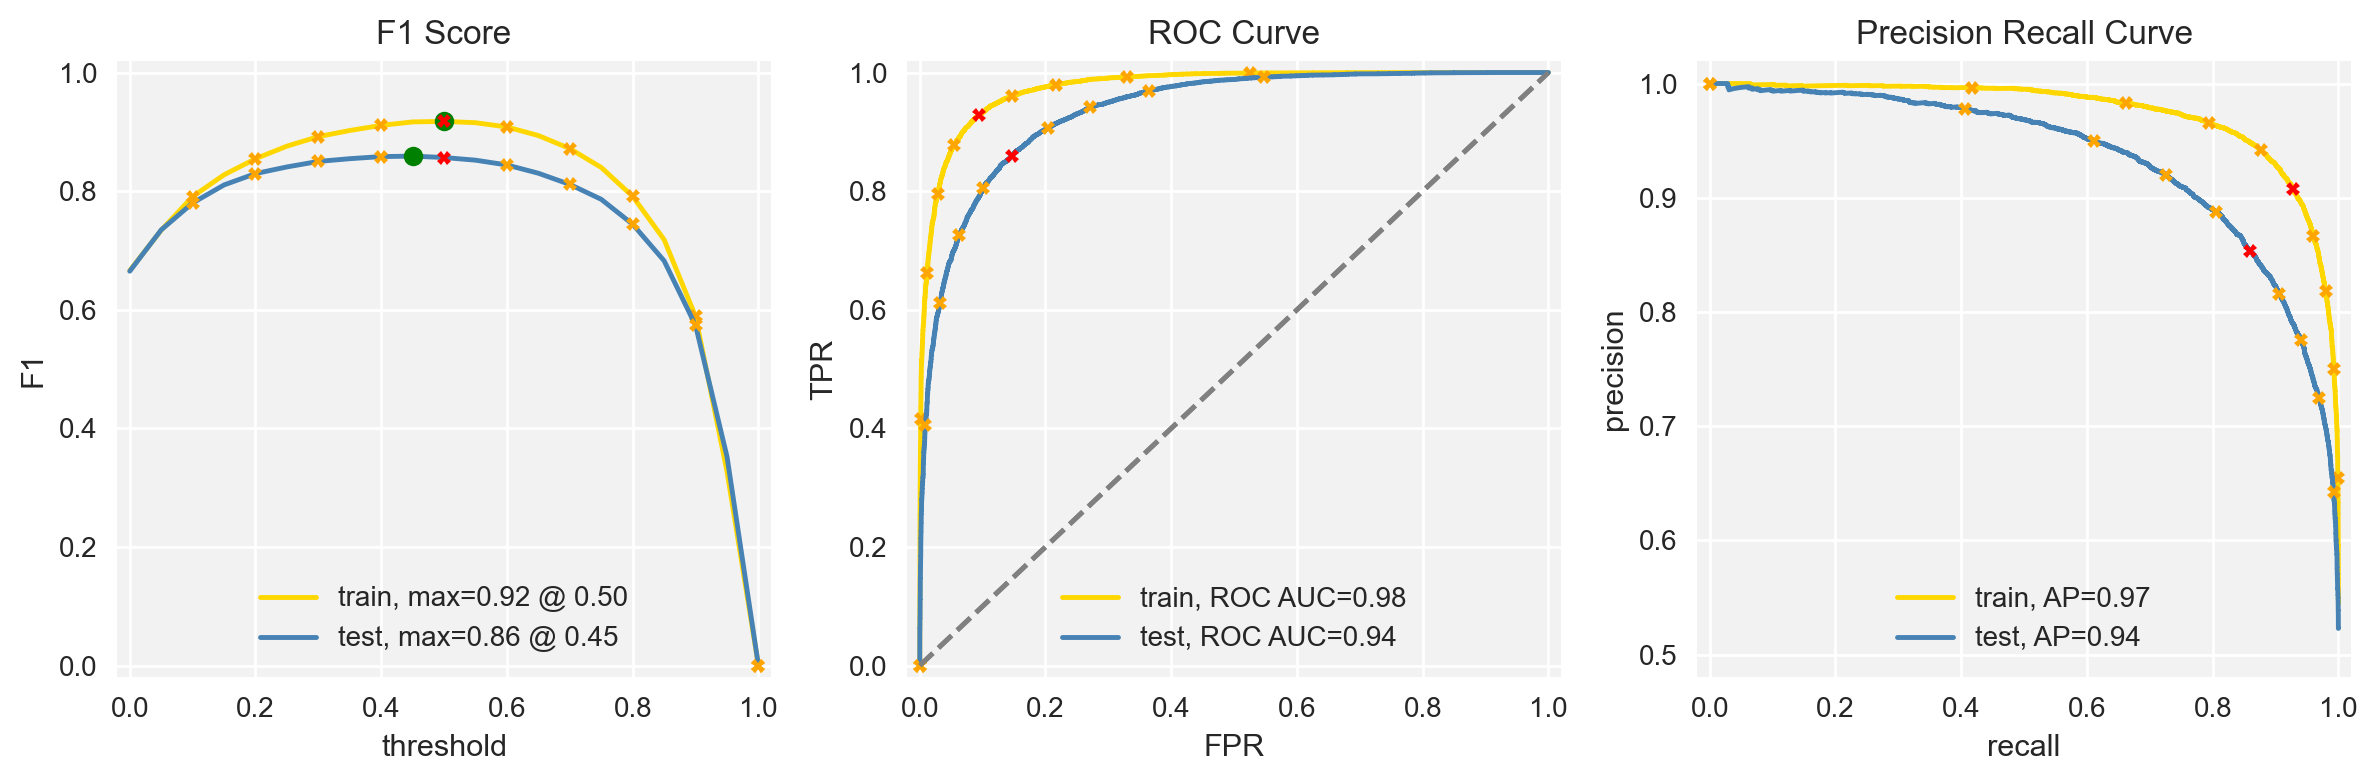

In [58]:
lgbm_3 = LGBMClassifier(random_state=1345, n_jobs=-1).fit(train_features_3, train_target)

evaluate_model(lgbm_3, train_features_3, train_target, test_features_3, test_target)

#### LGBM and BERT embeddings

,train,test
Accuracy,0.93,0.83
F1,0.93,0.84
APS,0.98,0.92
ROC AUC,0.98,0.92


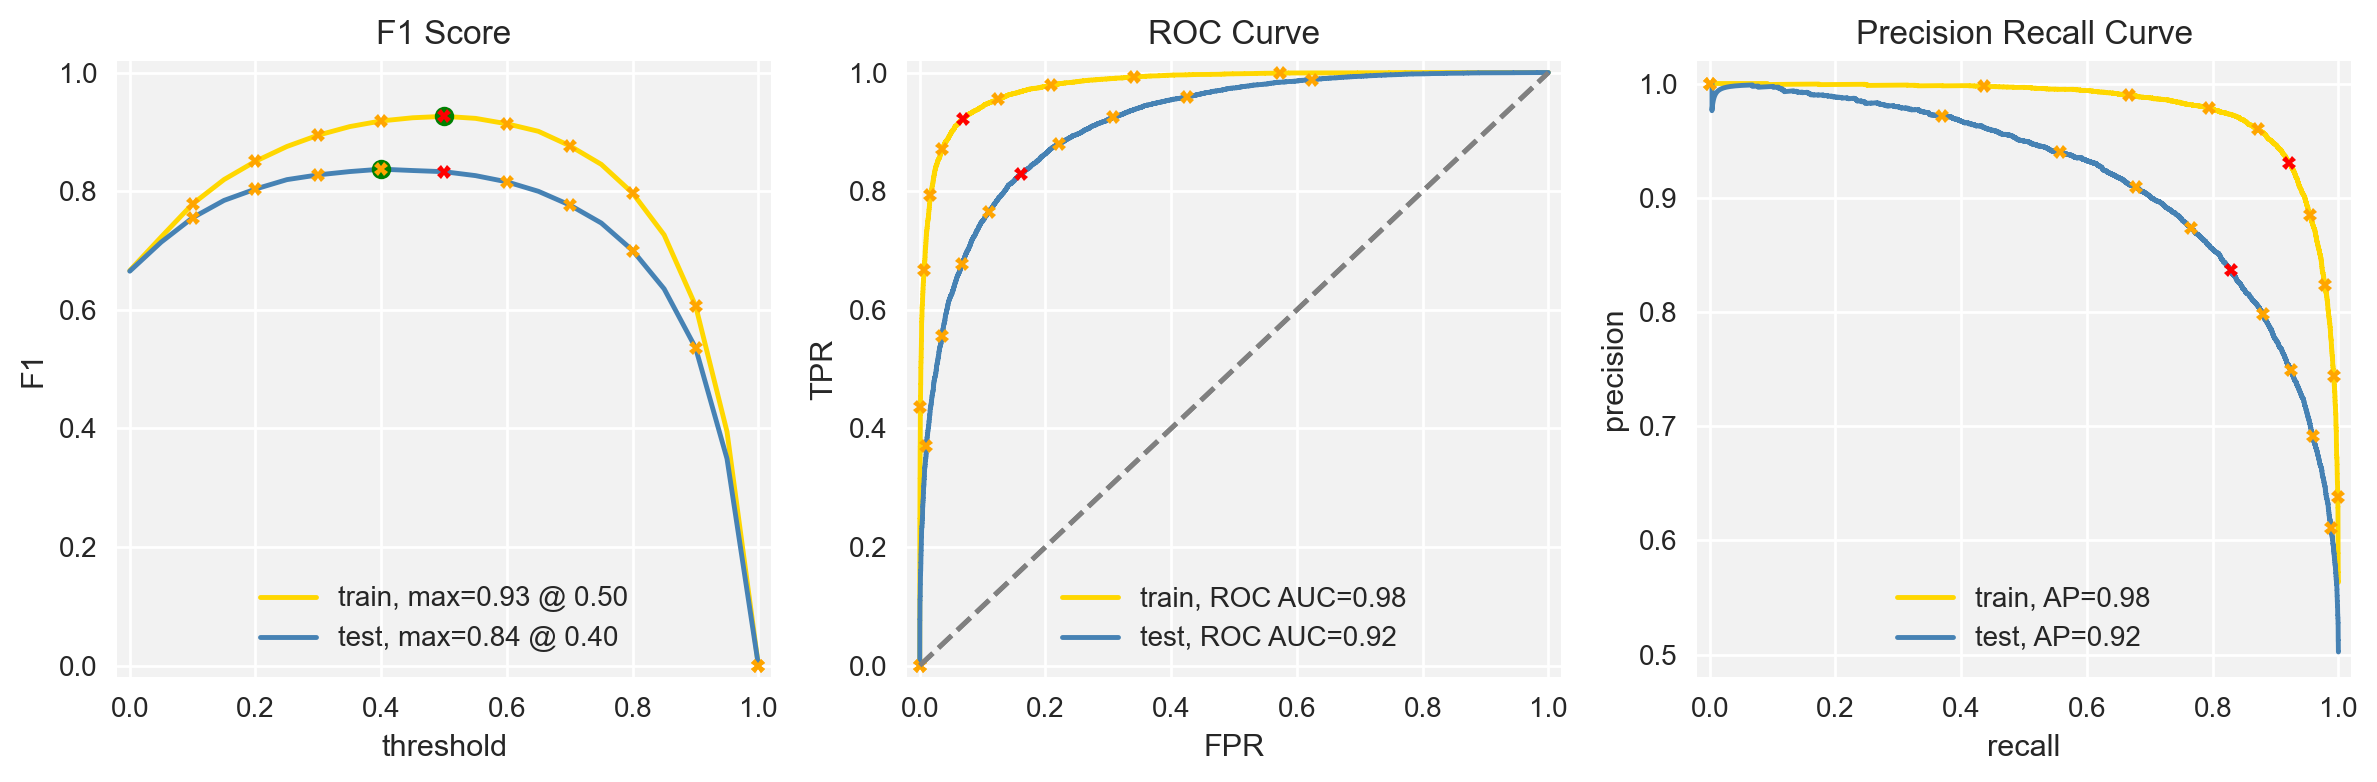

In [59]:
lgbm_5 = LGBMClassifier(random_state=1345, n_jobs=-1).fit(train_features_5, train_target)

evaluate_model(lgbm_5, train_features_5, train_target, test_features_5, test_target)

***

## Custom reviews test

Use some reviews with star rating from Google Audience to see how the model will label them.

In [60]:
new_reviews = pd.DataFrame(
    {"review":[
        "I like hard science fiction, when fantasy about possible events is grounded on current scientific facts. This movie does a good job in being fantastic enough, but not far from reality. With that said, I didn't really understand the motivation of the main character. She was presented as a very smart, wise person whose decisions made a huge impact on humanity. However, in the end, with all her knowledge, abilities, and absolute awareness, she makes an irrational, illogical, and unreasonable decision which causes suffering to two of her closest people. So, after all, the amazing events of the main part of the movie, are dimmed with this silly-human ending. Shame! But I like the movie, after all if I were me, I would watch it again.",
        "I have watched every marvel movie, loved most of them, this Thor movie very disappointing, like a really bad B grade sci-fi from syfy channel, I don't blame the actors, Hemsworth & Bale are great actors, script writers and director are to blame. It was like a poorly scripted 80s movie, meant to be funny but just sad, gaps in the story line that didn't add up, trying not to give away the plot for those who may be thinking of seeing the movie. Yes there has always been a humour element to the marvel movies, this one seriously missed the mark, it was  reminiscent of a terrible spoof Thor movie. 3 of us went to see the movie, we were looking at each other with an expression of what is going on. 30 mins into the movie, we decided to go outside, spoke to a couple of the cinema staff who all said your not the first ones to come out, general opinion is the movie is bizarre and waste of money. We debated on going back in to watch a bit more to see if it gets any better, tried again it didn't get any better, Russell Crowe playing the part of Zeus King of the gods, not the image of you would expect, more like a really overweight grandad in a tutu prancing around.",
        "Truly an enjoyable film, in some ways it felt different from most MCU films, and while it didn’t turn out to be as groundbreaking to critics as it’s predecessor, it proves to be the perfect superhero movie for the summer. Many others before me say that it didn’t have enough story, but let me tell you what it lacks in a “stellar” story it more than makes up for in action, humor, outstanding visuals, pop culture references, cameos, and overall creativity. While I was a little surprised not seeing Gorr do as much god butchering on screen, Christian Bale makes up for the character’s limited screen time through a powerful and albeit creepy performance, one scene in particular reminiscent of Pennywise from It, and his powers are unbelievably awesome. My only real complaints is are there is too much focus on the love story between Thor and Jane Foster, the first part of the film feels somewhat rushed (though I did enjoy the action packed ‘80s style fight), and of course without Loki, it just didn’t feel the same. Best of all, the mid and post credits scenes make me optimistic for the future of both Thor’s story and the MCU overall. My complaints are few and my thumbs are all the way up to the heavens to join the gods themselves 😇. Highly recommend this film, and please, don’t worry about what others think, go see it and make you’re own opinion ;). Also, Russell Crowe as Zeus was both powerful and hysterical, respect for holding the Greek accent 👍",
        "I still play it even today. The graphics are amazing for a 2010 game and the story and missions are so well done. It’s incredibly fun with 2 players and since there are so many things to do you never get bored. There is an entire story mode that takes a decent chunk of time to finish and then the toy box mode Has TONS more missions and a little story of its own. You unlock cars. Rideable animals. (Bullseye, dragons),weapons and way more things!. This game will always have a special place in my heart and I’m lucky I found it so many years ago. Honestly one of the best games I’ve ever played I even recommend it today. You get bored of the new games these days it’s nice to just go back and enjoy the old days",
        "Antman as a hero and a movie is underrated. Scott may be weird (which makes him different than the other Avengers and more funny) but his  ‘powers’ are really cool! This movie has action, great visuals, a well-written script, and has a few humorous lines/scenes. Honestly I wasn’t sure it was worth watching but I will now 100% recommend it to Marvel fans. It doesn’t have as much blood/gore, swearing, or violence as other Marvel movies, which can be a good or bad thing, but I think any Marvel fan should have no trouble enjoying it.",
        "Great film, new cast is great, my only thing is that there should have been way, way more action scenes. Think about the Matrix Reloaded, they built a freeway and there was a 30min car vs bike chase against the agents, Morpheus, the key maker and Trinity on a Ducatti no less, with Neo flying back to save them all at the last second before the two lorries collided in a huge explosion, in bullet time with each other. That scene still blows my mind to this day! In this one Neo can't even fly, there is way too much backstory, most people know the story of the Matrix already, so it needed more action and special effects. John Wick 3 Parrabellum was great with Keanu Reeves for that very reason it was full of gun crazed action from start to finish. If you're a fan of the original Matrix and in a nostalgic mood it's a must watch, but I can't help but think they will need to back up (no pun intended) the Matrix Resurrections with another film for newcomers to the franchise, who will be totally confused with the back and forth awkward slowness of this version of the Matrix and lack of action, fight scenes and passion the first Trilogy of Matrix films had to offer. Enjoy!",
        "I love the Matrix movies, and this one I thought was pretty good as well.  It’s been so long since I saw the trilogy that I was a little lost at first, mainly cause I had really forgotten what all happened to everyone, but after a refresher I was up to speed.  Keanu Reeves is great, but what I found that really surprised me is Neil Patrick Harris, he played that part remarkably well.  All in all, if you are a fan of the Matrix movies, as I am, you will like this movie too.  I hope this is the first of another possible trilogy and the story will continue on.  Not trying to disagree with those who didn’t like it, everyone has their own opinions, but maybe many fans was satisfied with how the trilogy concluded.  I could understand that point of view as well, and that some great things so just stay great and to leave it as it was, but hey, it makes for great conversation pieces.  The only negative I will say about the movie without giving any spoilers is that it was hard to follow along at the first, especially if you can’t remember the first three, so my suggestion is to maybe rewatch or watch for the first time, the first three movies and then flow into this new one. Just my opinion, everyone enjoy and god bless.",
        "This movie presented the whole story about the hero saving his lady and making her fall in love again ...in a very Nolanistic way. The action scenes felt very real but not of the level of the movie which is being made in the 2020s. the whole movie had this nostalgic effect to it by which you can make all your OG fans from the OF Matrix decade. This movie explained a lot of things that made people confused from watching the 2nd & 3rd parts of Quadrology. Loved the whole concept of the dream, use of your brains and imagination with your reality related to it in parallel... keep this concept n any type of movie and I am gonna love it, No doubt. But yes, Nothing can match the level - The Matrix(1999). And yes can we please talk about Casting Jonathan Groff as Mr. Smith, Omg this was soo good to see him After the series- Mindhunters.This film made me more eager for the 3rd season.P.S- The Cameo of Chelsea (Cat) in this movie was so unexpected and also the last 30 secs post credit scene was the best thing About the movie",
        "As a life long Matrix fan I was busting to see Resurrections 😀 I enjoyed it because the concepts and philosophy behind true reality intrigue me 🤔 If you are young and just go to the cinema to watch this film you will be so very DISAPPOINTED 😷 You will never be able to follow the plot. If you have not seen the previous 3 Matrix films you will subsequently fall asleep 🛏️ due to induced boardem. Even worse if you wanted great martial arts combat scenes 🥋 you are not getting any of those either 😤 All the action scenes were open to rubbish camera angles and a lack of awe and inspiration 🤯 The book 'Phenomenon' sold on Amazon 'Before Conception and Beyond' was Matrix 4 in many ways but unlike Resurrections ⚰️ the book takes you on the Greatest Adventure Ever Experienced 💡which cannot be said for the film sadly 🛀 The Phenomenon book plot is a very similar plot to the film and smashes into Matrix 5 'The Paradox' At least with the book 📚 'Phenomenon' you could put it down and raid the fridge for food 🌮and beers🍻. Honestly though 🤔 worth a watch if you are a true Matrix fan. If not honestly DON'T bother keep your money and buy the book. It will last longer and be more entertaining on your settee 🛋️ 📺  Hope you have enjoyed my review for you. Now it's time ☎️ for you to choose which pill 💊💊 to take. From a very rainy 🌧️ UK 🇬🇧 have a nice day 🌈🎱",
        "If you have seen the trilogy + you like lot of actions then their is a huge chance that you will be disappointed from this movie. But this movie is almost a decent sequel I would say because it provide us the depth into the characters of not only Neo but also Trinity. This movie gives equal value to both of them and is MORE OF A LOVE STORY than an action packed superhero type movie- so if you don't expected that from the movie you will hate it like most of the others are. For me, the climax and ending satisfied me and I expect that another sequel (if it comes ever) will have all that great fight what we were expecting from this movie. Otherwise the first two parts will only remain favourite for me forever 💗",
        "The Matrix: Resurrections sucks! it's worst Matrix movie ever and one of worst movies of 2021 also it did not feel like Matrix movie at all! The only good stuff I like was acting by some cast were great like Keanu Reeves was great as always as Neo along with Carrie-Anne Moss as Trinity, Jada Pinkett Smith as Niobe, and Priyanka Chopra as Sati, I like new character name Bugs who was played by Jessica Henwick even though it was confusing of where she came from, visuals effects were good, music was great, and fight scene were okay but mainly poorly. But bad stuff I hate recast of Morpheus who was played by Yahya Abdul-Mateen II being because Laurence Fishburne will always be Morpheus so it was stupid move, came out no where of villain name The Analyst when he saw Neo and Trinity dying in Revolutions, some of new powers did not make any sense at all like Analyst's power to slow down time, I hate they underuse Trinity, I hate how this movie rehash of first Matrix, I hate they brought back Agent Smith to life no offense he is defiantly one best cinematic villain especially that he was played by Hugo Weaving from The Matrix Trilogy but it was bad idea to bring him back to life and should stay dead also Jonathan Groff was bad choice to Agent Smith, ending was so bad, and my most biggest problem of this movie was Neo being video game maker and made The Matrix Trilogy and was making 4th one and it so stupid and bad! So yeah I think this movie is very unnecessary sequel and that Revolution was great ending to franchise. But because some few stuff that I like from movie that I had mention I would give this movie a 3/10 and I would defiantly watch 2 first sequels to The Matrix over 4th sequel."
    ],
    "stars":[4, 1, 4, 3, 5, 3, 5, 2, 4, 3, 2]}
)

#### Normalize texts

In [61]:
new_reviews["review_norm"] = [
    " ".join( # split and join to remove extra spaces made after substitution
        re.sub(r"[^a-z']"," ", text.lower()).split() # substitute all characters      
    )                                                # that don't fit the pattern
    for text 
    in new_reviews["review"]
]

#### LR and NLTK lemmatization

In [64]:
# lemmatize
corpus = [
    " ".join(
        [lemmatizer.lemmatize(token) for token in word_tokenize(text)]
    )
    for text
    in new_reviews["review_norm"]
]
stars = new_reviews["stars"]
# give vectors
vectors = vectorizer_1.transform(corpus)
# get predictions
new_reviews_prob_pred = lr_1.predict_proba(vectors)[:, 1]

for i, review in enumerate(new_reviews["review"].str.slice(0,100)):
    print("{} stars,  {:.2f} pred | {}".format(stars[i],new_reviews_prob_pred[i], review))

4 stars,  0.65 pred | I like hard science fiction, when fantasy about possible events is grounded on current scientific fa
1 stars,  0.05 pred | I have watched every marvel movie, loved most of them, this Thor movie very disappointing, like a re
4 stars,  0.99 pred | Truly an enjoyable film, in some ways it felt different from most MCU films, and while it didn’t tur
3 stars,  0.96 pred | I still play it even today. The graphics are amazing for a 2010 game and the story and missions are 
5 stars,  0.78 pred | Antman as a hero and a movie is underrated. Scott may be weird (which makes him different than the o
3 stars,  0.48 pred | Great film, new cast is great, my only thing is that there should have been way, way more action sce
5 stars,  0.96 pred | I love the Matrix movies, and this one I thought was pretty good as well.  It’s been so long since I
2 stars,  0.74 pred | This movie presented the whole story about the hero saving his lady and making her fall in love agai
4 stars,  0.46 p

#### LR and BERT embeddings

In [66]:
vectors_bert = get_bert_embeddings(new_reviews["review_norm"], batch_size=64)

# get predictions
new_reviews_prob_pred = lr_5.predict_proba(vectors_bert)[:, 1]

for i, review in enumerate(new_reviews["review"].str.slice(0,100)):
    print("{} stars,  {:.2f} pred | {}".format(stars[i],new_reviews_prob_pred[i], review))

100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 353.06it/s]


Using the mps device.


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

4 stars,  0.35 pred | I like hard science fiction, when fantasy about possible events is grounded on current scientific fa
1 stars,  0.09 pred | I have watched every marvel movie, loved most of them, this Thor movie very disappointing, like a re
4 stars,  0.72 pred | Truly an enjoyable film, in some ways it felt different from most MCU films, and while it didn’t tur
3 stars,  1.00 pred | I still play it even today. The graphics are amazing for a 2010 game and the story and missions are 
5 stars,  0.99 pred | Antman as a hero and a movie is underrated. Scott may be weird (which makes him different than the o
3 stars,  0.86 pred | Great film, new cast is great, my only thing is that there should have been way, way more action sce
5 stars,  0.77 pred | I love the Matrix movies, and this one I thought was pretty good as well.  It’s been so long since I
2 stars,  0.94 pred | This movie presented the whole story about the hero saving his lady and making her fall in love agai
4 stars,  0.89 p

#### RF and NLTK lemmatization

In [70]:
# get predictions
new_reviews_prob_pred = forest_11.predict_proba(vectors)[:, 1]

for i, review in enumerate(new_reviews["review"].str.slice(0,100)):
    print("{} stars,  {:.2f} pred | {}".format(stars[i],new_reviews_prob_pred[i], review))

4 stars,  0.56 pred | I like hard science fiction, when fantasy about possible events is grounded on current scientific fa
1 stars,  0.30 pred | I have watched every marvel movie, loved most of them, this Thor movie very disappointing, like a re
4 stars,  0.71 pred | Truly an enjoyable film, in some ways it felt different from most MCU films, and while it didn’t tur
3 stars,  0.72 pred | I still play it even today. The graphics are amazing for a 2010 game and the story and missions are 
5 stars,  0.42 pred | Antman as a hero and a movie is underrated. Scott may be weird (which makes him different than the o
3 stars,  0.50 pred | Great film, new cast is great, my only thing is that there should have been way, way more action sce
5 stars,  0.67 pred | I love the Matrix movies, and this one I thought was pretty good as well.  It’s been so long since I
2 stars,  0.53 pred | This movie presented the whole story about the hero saving his lady and making her fall in love agai
4 stars,  0.48 p

***

## Conclusions

1. EDA part showed that the dataset was split into the train and test parts evenly: the target class is balanced, the distribution of ratings, number of reviews, and dates in both sets is similar.   

2. For text processing the NLTK package shows both better quality (when tested on with ML model) and the speed of preprocessing than that with spaCy. Stemming shows no significant difference compared to lemmatization. Using n_grams showed no improvement compared to single word TF-IDF vectorizing. Using BERT encoding gives slightly worse results than simple lemmatization/stemming + TF-IDF techniques. 

3. Among ML models and text processing techniques tested in this project, the simple logistic regression with either stemming or lemmatization, plus N-grams vectorizing showed the best F1 score of `0.89`, which is 24% better than the baseline. Using more complex models for both text processing and making predictions doesn't give better results.